<a href="https://colab.research.google.com/github/msmsd778/First-Impressions-V2/blob/main/First_Impressions_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading and Preprocessing

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

Mounted at /content/drive


In [ ]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 4.3 MB/s eta 0:00:00


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import re
import contractions


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = str(text).lower()

    # Remove links
    text = re.sub(r'https?:\/\/.*?[\s+]', '', text.replace("|", " ") + " ")

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove multiple fullstops
    text = re.sub(r'[^\w\s]','', text)

    # Remove multiple letter repeating words
    text = re.sub(r'([a-z])\1{2,}[\s|\w]*','', text)

    # Remove Non-words
    text = re.sub(r'[^a-zA-Z\s]','', text)

    # Remove very short or long words
    text = re.sub(r'(\b\w{0,2})?\b','', text)
    text = re.sub(r'(\b\w{20,1000})?\b','', text)

    # Remove numbers and special characters
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    # Expand contractions
    text = contractions.fix(text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Perform part-of-speech tagging
    tagged_tokens = pos_tag(filtered_tokens)

    # Lemmatize tokens based on their part-of-speech tags
    lemmatized_tokens = []
    for token, tag in tagged_tokens:
        wordnet_tag = get_wordnet_pos(tag)
        lemmatized_token = lemmatizer.lemmatize(token, pos=wordnet_tag) if wordnet_tag else lemmatizer.lemmatize(token)
        lemmatized_tokens.append(lemmatized_token)

    return lemmatized_tokens

# Function to map part-of-speech tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # Adjective
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('N'):
        return 'n'  # Noun
    elif tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return None  # None by default

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import pickle

# Open the pickle file
with open('/content/drive/MyDrive/NLP/transcription_training.pkl', 'rb') as f:
    data = pickle.load(f)

# Create a dictionary that maps column names to lists of values
df_dict = {
    'video_id': list(data.keys()),
    'text': list(data.values())
}

# Convert the dictionary to a pandas DataFrame
df1 = pd.DataFrame(df_dict)
df1

video_id                                               text
0     J4GQm9j0JZ0.003.mp4  He's cutting it and then turn around and see t...
1     zEyRyTnIw5I.005.mp4  Responsibility to house the organ I had been g...
2     nskJh7v6v1U.004.mp4  I actually got quite a few sets of black pens ...
3     6wHQsN5g2RM.000.mp4  I ate a lot. I'd like a lot of foods. I rememb...
4     dQOeQYWIgm8.000.mp4  Now I'll ask you guys to leave a question in t...
...                   ...                                                ...
5995  mhF4kYTlVUE.001.mp4  I got to see a lot, got to experience a lot. Y...
5996  2q8orkMs2Jg.003.mp4  Really, really love my job, love the people I ...
5997  F1lAPYh4t3U.000.mp4  I have a nine-to-five. I said this in my last ...
5998  cxJ0u6r0-pU.001.mp4  You want to be working with and who you want t...
5999  hfUH9Am-Izs.000.mp4  No, but, it's really hard to explain. It reall...

[6000 rows x 2 columns]

In [ ]:
# load labels data
with open('/content/drive/MyDrive/NLP/annotation_training.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

# Convert the dictionary to a DataFrame
df11 = pd.DataFrame.from_dict(data)

# Transpose the DataFrame so that each row contains a video_id and the probabilities for each personality trait
df11 = df11.reset_index()

# # Rename the columns
df11.columns = ['video_id', 'extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'interview', 'openness']
df11

video_id  extraversion  neuroticism  agreeableness  \
0     J4GQm9j0JZ0.003.mp4      0.523364     0.552083       0.626374   
1     zEyRyTnIw5I.005.mp4      0.345794     0.375000       0.472527   
2     nskJh7v6v1U.004.mp4      0.252336     0.291667       0.406593   
3     6wHQsN5g2RM.000.mp4      0.457944     0.489583       0.505495   
4     dQOeQYWIgm8.000.mp4      0.607477     0.489583       0.406593   
...                   ...           ...          ...            ...   
5995  Eh7WRYXVh9M.000.mp4      0.523364     0.479167       0.626374   
5996  2q8orkMs2Jg.003.mp4      0.728972     0.760417       0.582418   
5997  F1lAPYh4t3U.000.mp4      0.700935     0.770833       0.747253   
5998  cxJ0u6r0-pU.001.mp4      0.317757     0.531250       0.582418   
5999  hfUH9Am-Izs.000.mp4      0.401869     0.500000       0.461538   

      conscientiousness  interview  openness  
0              0.601942   0.504673  0.488889  
1              0.582524   0.457944  0.366667  
2              0.485437   0.373832  0.511111  
3              0.398058   0.457944  0.377778  
4              0.621359   0.570093  0.622222  
...                 ...        ...       ...  
5995           0.621359   0.588785  0.544444  
5996           0.524272   0.616822  0.822222  
5997           0.699029   0.691589  0.788889  
5998           0.679612   0.616822  0.588889  
5999           0.543689   0.429907  0.588889  

[6000 rows x 7 columns]

In [ ]:
training_df = pd.merge(df1, df11, on='video_id')
training_df = training_df.drop(['interview', 'video_id'], axis=1)
training_df = training_df.dropna(subset=['text'])
training_df['text'] = training_df['text'].apply(preprocess_text)
training_df

text  extraversion  \
0     [he, cut, turn, around, see, end, result, glad...      0.523364   
1     [responsibility, house, organ, give, need, tel...      0.345794   
2     [actually, get, quite, set, black, pen, year, ...      0.252336   
3     [ate, lot, like, lot, food, remember, favorite...      0.457944   
4     [ill, ask, guy, leave, question, comment, hope...      0.607477   
...                                                 ...           ...   
5995  [get, see, lot, get, experience, lot, yeah, kn...      0.401869   
5996  [really, really, love, job, love, people, work...      0.728972   
5997  [ninetofive, say, last, ninetofive, per, proba...      0.700935   
5998  [want, work, want, help, bring, anyone, could,...      0.317757   
5999  [really, hard, explain, really, somebody, ask,...      0.401869   

      neuroticism  agreeableness  conscientiousness  openness  
0        0.552083       0.626374           0.601942  0.488889  
1        0.375000       0.472527           0.582524  0.366667  
2        0.291667       0.406593           0.485437  0.511111  
3        0.489583       0.505495           0.398058  0.377778  
4        0.489583       0.406593           0.621359  0.622222  
...           ...            ...                ...       ...  
5995     0.427083       0.571429           0.485437  0.466667  
5996     0.760417       0.582418           0.524272  0.822222  
5997     0.770833       0.747253           0.699029  0.788889  
5998     0.531250       0.582418           0.679612  0.588889  
5999     0.500000       0.461538           0.543689  0.588889  

[6000 rows x 6 columns]

In [ ]:
# Open the pickle file
with open('/content/drive/MyDrive/NLP/transcription_validation.pkl', 'rb') as f:
    data = pickle.load(f)

# Create a dictionary that maps column names to lists of values
df_dict = {
    'video_id': list(data.keys()),
    'text': list(data.values())
}

# Convert the dictionary to a pandas DataFrame
df2 = pd.DataFrame(df_dict)
df2

video_id                                               text
0     LNM1i-a9q_A.005.mp4  [inaudible 00:00:16] and then I will do the vo...
1     n6JNJurop2U.005.mp4  Personality is A1, I like you. So that is all ...
2     WER4ww680QQ.004.mp4  Ewe. But yeah, some people been asking me if I...
3     c4XnKouozXU.002.mp4  I am a makeup artist, I am an aesthetician, I ...
4     OEKg-Tvwcbk.002.mp4  Sucks. When he agrees, yeah. It just sucks bec...
...                   ...                                                ...
1995  3LAaFUSGvsU.000.mp4  Really qualified to. The guy who last week was...
1996  n2BuwHbdilY.000.mp4  Wearing scarfs on the second date. Okay, so no...
1997  GcuoyJPO-KU.003.mp4  "How do you manage to do things with someone? ...
1998  uf_sIIw4zxY.004.mp4  -I sell. No. Sophie Loveland, "Will you be pos...
1999  jd9_8OPxM3A.003.mp4  -to live together and to create a world where ...

[2000 rows x 2 columns]

In [ ]:
# load labels data
with open('/content/drive/MyDrive/NLP/annotation_validation.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

# Convert the dictionary to a DataFrame
df22 = pd.DataFrame.from_dict(data)

# Transpose the DataFrame so that each row contains a video_id and the probabilities for each personality trait
df22 = df22.reset_index()

# Rename the columns
df22.columns = ['video_id', 'extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'interview', 'openness']
df22

video_id  extraversion  neuroticism  agreeableness  \
0     modNfUPt3F4.002.mp4      0.644860     0.593750       0.615385   
1     h6LOjpCRXtY.005.mp4      0.439252     0.520833       0.417582   
2     WER4ww680QQ.004.mp4      0.457944     0.312500       0.428571   
3     c4XnKouozXU.002.mp4      0.364486     0.572917       0.527473   
4     OEKg-Tvwcbk.002.mp4      0.345794     0.468750       0.516484   
...                   ...           ...          ...            ...   
1995  3LAaFUSGvsU.000.mp4      0.570093     0.614583       0.494505   
1996  n2BuwHbdilY.000.mp4      0.542056     0.541667       0.549451   
1997  GcuoyJPO-KU.003.mp4      0.551402     0.593750       0.560440   
1998  uf_sIIw4zxY.004.mp4      0.514019     0.552083       0.461538   
1999  jd9_8OPxM3A.003.mp4      0.560748     0.635417       0.725275   

      conscientiousness  interview  openness  
0              0.640777   0.616822  0.555556  
1              0.572816   0.439252  0.411111  
2              0.398058   0.373832  0.555556  
3              0.553398   0.523364  0.322222  
4              0.417476   0.383178  0.477778  
...                 ...        ...       ...  
1995           0.689320   0.626168  0.577778  
1996           0.669903   0.579439  0.666667  
1997           0.572816   0.504673  0.644444  
1998           0.572816   0.551402  0.733333  
1999           0.621359   0.635514  0.666667  

[2000 rows x 7 columns]

In [ ]:
validation_df = pd.merge(df2, df22, on='video_id')
validation_df = validation_df.drop(['interview', 'video_id'], axis=1)
validation_df = validation_df.dropna(subset=['text'])
validation_df['text'] = validation_df['text'].apply(preprocess_text)
validation_df

text  extraversion  \
0     [inaudible, voice, ill, shot, talk, camera, we...      0.551402   
1     [personality, like, question, four, minute, to...      0.598131   
2     [ewe, yeah, people, ask, still, like, one, dir...      0.457944   
3     [makeup, artist, aesthetician, someone, also, ...      0.364486   
4     [suck, agree, yeah, suck, hot, walk, girl, kno...      0.345794   
...                                                 ...           ...   
1995  [really, qualify, guy, last, week, accountant,...      0.570093   
1996  [wear, scarfs, second, date, okay, hat, scarf,...      0.542056   
1997  [manage, thing, someone, get, used, shape, acr...      0.551402   
1998  [sell, sophie, loveland, post, video, wed, you...      0.514019   
1999  [live, together, create, world, coexist, inter...      0.560748   

      neuroticism  agreeableness  conscientiousness  openness  
0        0.770833       0.549451           0.669903  0.577778  
1        0.510417       0.692308           0.524272  0.588889  
2        0.312500       0.428571           0.398058  0.555556  
3        0.572917       0.527473           0.553398  0.322222  
4        0.468750       0.516484           0.417476  0.477778  
...           ...            ...                ...       ...  
1995     0.614583       0.494505           0.689320  0.577778  
1996     0.541667       0.549451           0.669903  0.666667  
1997     0.593750       0.560440           0.572816  0.644444  
1998     0.552083       0.461538           0.572816  0.733333  
1999     0.635417       0.725275           0.621359  0.666667  

[2000 rows x 6 columns]

In [ ]:
# Open the pickle file
with open('/content/drive/MyDrive/NLP/transcription_test.pkl', 'rb') as f:
    data = pickle.load(f)

# Create a dictionary that maps column names to lists of values
df_dict = {
    'video_id': list(data.keys()),
    'text': list(data.values())
}

# Convert the dictionary to a pandas DataFrame
df3 = pd.DataFrame(df_dict)
df3

video_id                                               text
0     htH89DBizno.004.mp4  ... Going nuts from another room, run in there...
1     p_wf-KszNlk.001.mp4  I've got a little bit to go but we need you th...
2     MuYYY3XaJ7Q.001.mp4  A video's quality over quantity, so everyone c...
3     0MB91ku0eEw.005.mp4  You really want to. That's made things a lot e...
4     WpEZOSrENL0.003.mp4  That's perfectly okay. The point isn't actuall...
...                   ...                                                ...
1995  NzCflfxgvwo.001.mp4  Du du du. No, that's not why I made this video...
1996  ch2BcBv4SdQ.003.mp4                           They do it all the time.
1997  It0-yCwOc5k.001.mp4  Comfortable and I don't want anyone to feel un...
1998  1Wh2mIFrGvk.000.mp4  You're not giving yourself enough calories to ...
1999  a97PXgrKSxo.002.mp4  Eat enough carbs, eat more fats to get in more...

[2000 rows x 2 columns]

In [ ]:
# load labels data
with open('/content/drive/MyDrive/NLP/annotation_test.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

# Convert the dictionary to a DataFrame
df33 = pd.DataFrame.from_dict(data)

# Transpose the DataFrame so that each row contains a video_id and the probabilities for each personality trait
df33 = df33.reset_index()

# # Rename the columns
df33.columns = ['video_id', 'extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'interview', 'openness']
df33

video_id  extraversion  neuroticism  agreeableness  \
0     htH89DBizno.004.mp4      0.485981     0.645833       0.681319   
1     p_wf-KszNlk.001.mp4      0.616822     0.593750       0.692308   
2     MuYYY3XaJ7Q.001.mp4      0.467290     0.625000       0.560440   
3     0MB91ku0eEw.005.mp4      0.411215     0.458333       0.714286   
4     WpEZOSrENL0.003.mp4      0.317757     0.437500       0.384615   
...                   ...           ...          ...            ...   
1995  NzCflfxgvwo.001.mp4      0.289720     0.312500       0.208791   
1996  ch2BcBv4SdQ.003.mp4      0.719626     0.781250       0.670330   
1997  It0-yCwOc5k.001.mp4      0.355140     0.395833       0.472527   
1998  1Wh2mIFrGvk.000.mp4      0.467290     0.645833       0.527473   
1999  a97PXgrKSxo.002.mp4      0.654206     0.635417       0.813187   

      conscientiousness  interview  openness  
0              0.669903   0.626168  0.822222  
1              0.514563   0.570093  0.655556  
2              0.524272   0.514019  0.522222  
3              0.660194   0.570093  0.400000  
4              0.524272   0.448598  0.411111  
...                 ...        ...       ...  
1995           0.135922   0.177570  0.300000  
1996           0.572816   0.728972  0.722222  
1997           0.446602   0.411215  0.677778  
1998           0.669903   0.560748  0.622222  
1999           0.728155   0.654206  0.588889  

[2000 rows x 7 columns]

In [ ]:
test_df = pd.merge(df3, df33, on='video_id')
test_df = test_df.drop(['interview', 'video_id'], axis=1)
test_df = test_df.dropna(subset=['text'])
test_df['text'] = test_df['text'].apply(preprocess_text)
test_df

text  extraversion  \
0     [go, nut, another, room, run, check, inaudible...      0.485981   
1     [get, little, bit, need, soi, decide, video, o...      0.616822   
2     [video, quality, quantity, everyone, chance, w...      0.467290   
3     [really, want, make, thing, lot, easy, meet, p...      0.411215   
4     [perfectly, okay, point, actually, find, answe...      0.317757   
...                                                 ...           ...   
1995  [make, video, make, video, know, tyler, make, ...      0.289720   
1996                                             [time]      0.719626   
1997  [comfortable, want, anyone, feel, uncomfortabl...      0.355140   
1998  [give, enough, calorie, put, new, muscle, new,...      0.467290   
1999  [eat, enough, carbs, eat, fat, get, calorie, t...      0.654206   

      neuroticism  agreeableness  conscientiousness  openness  
0        0.645833       0.681319           0.669903  0.822222  
1        0.593750       0.692308           0.514563  0.655556  
2        0.625000       0.560440           0.524272  0.522222  
3        0.458333       0.714286           0.660194  0.400000  
4        0.437500       0.384615           0.524272  0.411111  
...           ...            ...                ...       ...  
1995     0.312500       0.208791           0.135922  0.300000  
1996     0.781250       0.670330           0.572816  0.722222  
1997     0.395833       0.472527           0.446602  0.677778  
1998     0.645833       0.527473           0.669903  0.622222  
1999     0.635417       0.813187           0.728155  0.588889  

[2000 rows x 6 columns]

In [ ]:
training_df['text_size'] = training_df['text'].apply(len)
max_size = training_df['text_size'].max()
min_size = training_df['text_size'].min()
avg_size = training_df['text_size'].mean()
print("maximum text length:", max_size)
print("minimum text length:", min_size)
print("average text length:", avg_size)

maximum text length: 37
minimum text length: 0
average text length: 18.087666666666667


In [ ]:
validation_df['text_size'] = validation_df['text'].apply(len)
max_size = validation_df['text_size'].max()
min_size = validation_df['text_size'].min()
avg_size = validation_df['text_size'].mean()
print("maximum text length:", max_size)
print("minimum text length:", min_size)
print("average text length:", avg_size)

maximum text length: 40
minimum text length: 0
average text length: 18.2045


In [ ]:
test_df['text_size'] = test_df['text'].apply(len)
max_size = test_df['text_size'].max()
min_size = test_df['text_size'].min()
avg_size = test_df['text_size'].mean()
print("maximum text length:", max_size)
print("minimum text length:", min_size)
print("average text length:", avg_size)

maximum text length: 35
minimum text length: 0
average text length: 18.1515


In [ ]:
training_df = training_df.drop(training_df[training_df['text_size'] == 0].index)
validation_df = validation_df.drop(validation_df[validation_df['text_size'] == 0].index)
test_df = test_df.drop(test_df[test_df['text_size'] == 0].index)

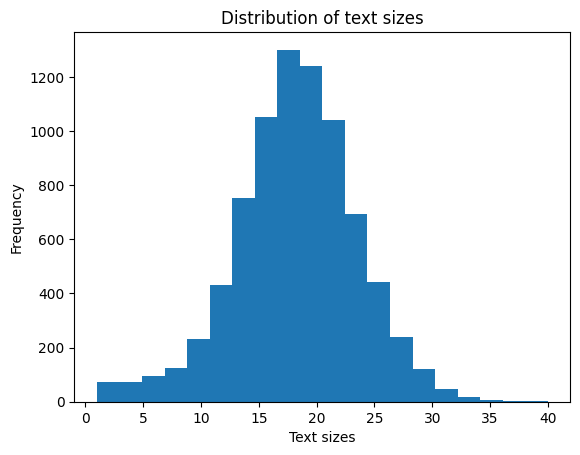

In [ ]:
sizes = pd.concat([training_df, validation_df])['text_size']
plt.hist(sizes, bins=20)

plt.xlabel('Text sizes')
plt.ylabel('Frequency')
plt.title('Distribution of text sizes')

plt.show()

In [ ]:
max_sequence_length = 32

In [ ]:
from collections import Counter

min_count = 1
token_counter = Counter()
for tokens in training_df['text']:
    token_counter.update(tokens)

vocabulary = {'<pad>': 0, '<unk>': 1}
for token, count in token_counter.items():
    if count >= min_count:
        vocabulary[token] = len(vocabulary)

In [ ]:
len(vocabulary)

9054

In [ ]:
# file_path = '/content/drive/My Drive/NLP/vocab_impressions.pkl'
# with open(file_path, 'wb') as f:
#     pickle.dump(vocabulary, f)

In [ ]:
file_path = '/content/drive/My Drive/NLP/vocab_impressions.pkl'
with open(file_path, 'rb') as f:
    vocabulary = pickle.load(f)

In [ ]:
# Truncate lists to maximum length
training_df['text'] = training_df['text'].apply(lambda tokens: tokens[:max_sequence_length])
validation_df['text'] = validation_df['text'].apply(lambda tokens: tokens[:max_sequence_length])
test_df['text'] = test_df['text'].apply(lambda tokens: tokens[:max_sequence_length])

In [ ]:
# Pad and map the text data
def pad_and_map_sequence(sequence):
    truncated_sequence = sequence[:max_sequence_length]
    padded_sequence = truncated_sequence + ['<pad>'] * (max_sequence_length - len(truncated_sequence))
    mapped_sequence = [vocabulary.get(token, vocabulary['<unk>']) for token in padded_sequence]
    return mapped_sequence

In [ ]:
# Padding and mapping lists to maximum length
training_df['text_indices'] = training_df['text'].apply(pad_and_map_sequence)
validation_df['text_indices'] = validation_df['text'].apply(pad_and_map_sequence)
test_df['text_indices'] = test_df['text'].apply(pad_and_map_sequence)

In [ ]:
print(validation_df.iloc[2]['text_indices'])

[1, 257, 53, 72, 98, 21, 46, 459, 22, 98, 21, 215, 46, 459, 1738, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
training_df.head()

text  extraversion  \
0  [he, cut, turn, around, see, end, result, glad...      0.523364   
1  [responsibility, house, organ, give, need, tel...      0.345794   
2  [actually, get, quite, set, black, pen, year, ...      0.252336   
3  [ate, lot, like, lot, food, remember, favorite...      0.457944   
4  [ill, ask, guy, leave, question, comment, hope...      0.607477   

   neuroticism  agreeableness  conscientiousness  openness  text_size  \
0     0.552083       0.626374           0.601942  0.488889         22   
1     0.375000       0.472527           0.582524  0.366667         17   
2     0.291667       0.406593           0.485437  0.511111         27   
3     0.489583       0.505495           0.398058  0.377778         21   
4     0.489583       0.406593           0.621359  0.622222         21   

                                        text_indices  
0  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3...  
1  [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 25, 3...  
2  [39, 14, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4...  
3  [58, 56, 21, 56, 59, 60, 61, 62, 63, 64, 65, 6...  
4  [71, 72, 73, 74, 75, 76, 77, 71, 14, 75, 29, 7...

#Word Clouds

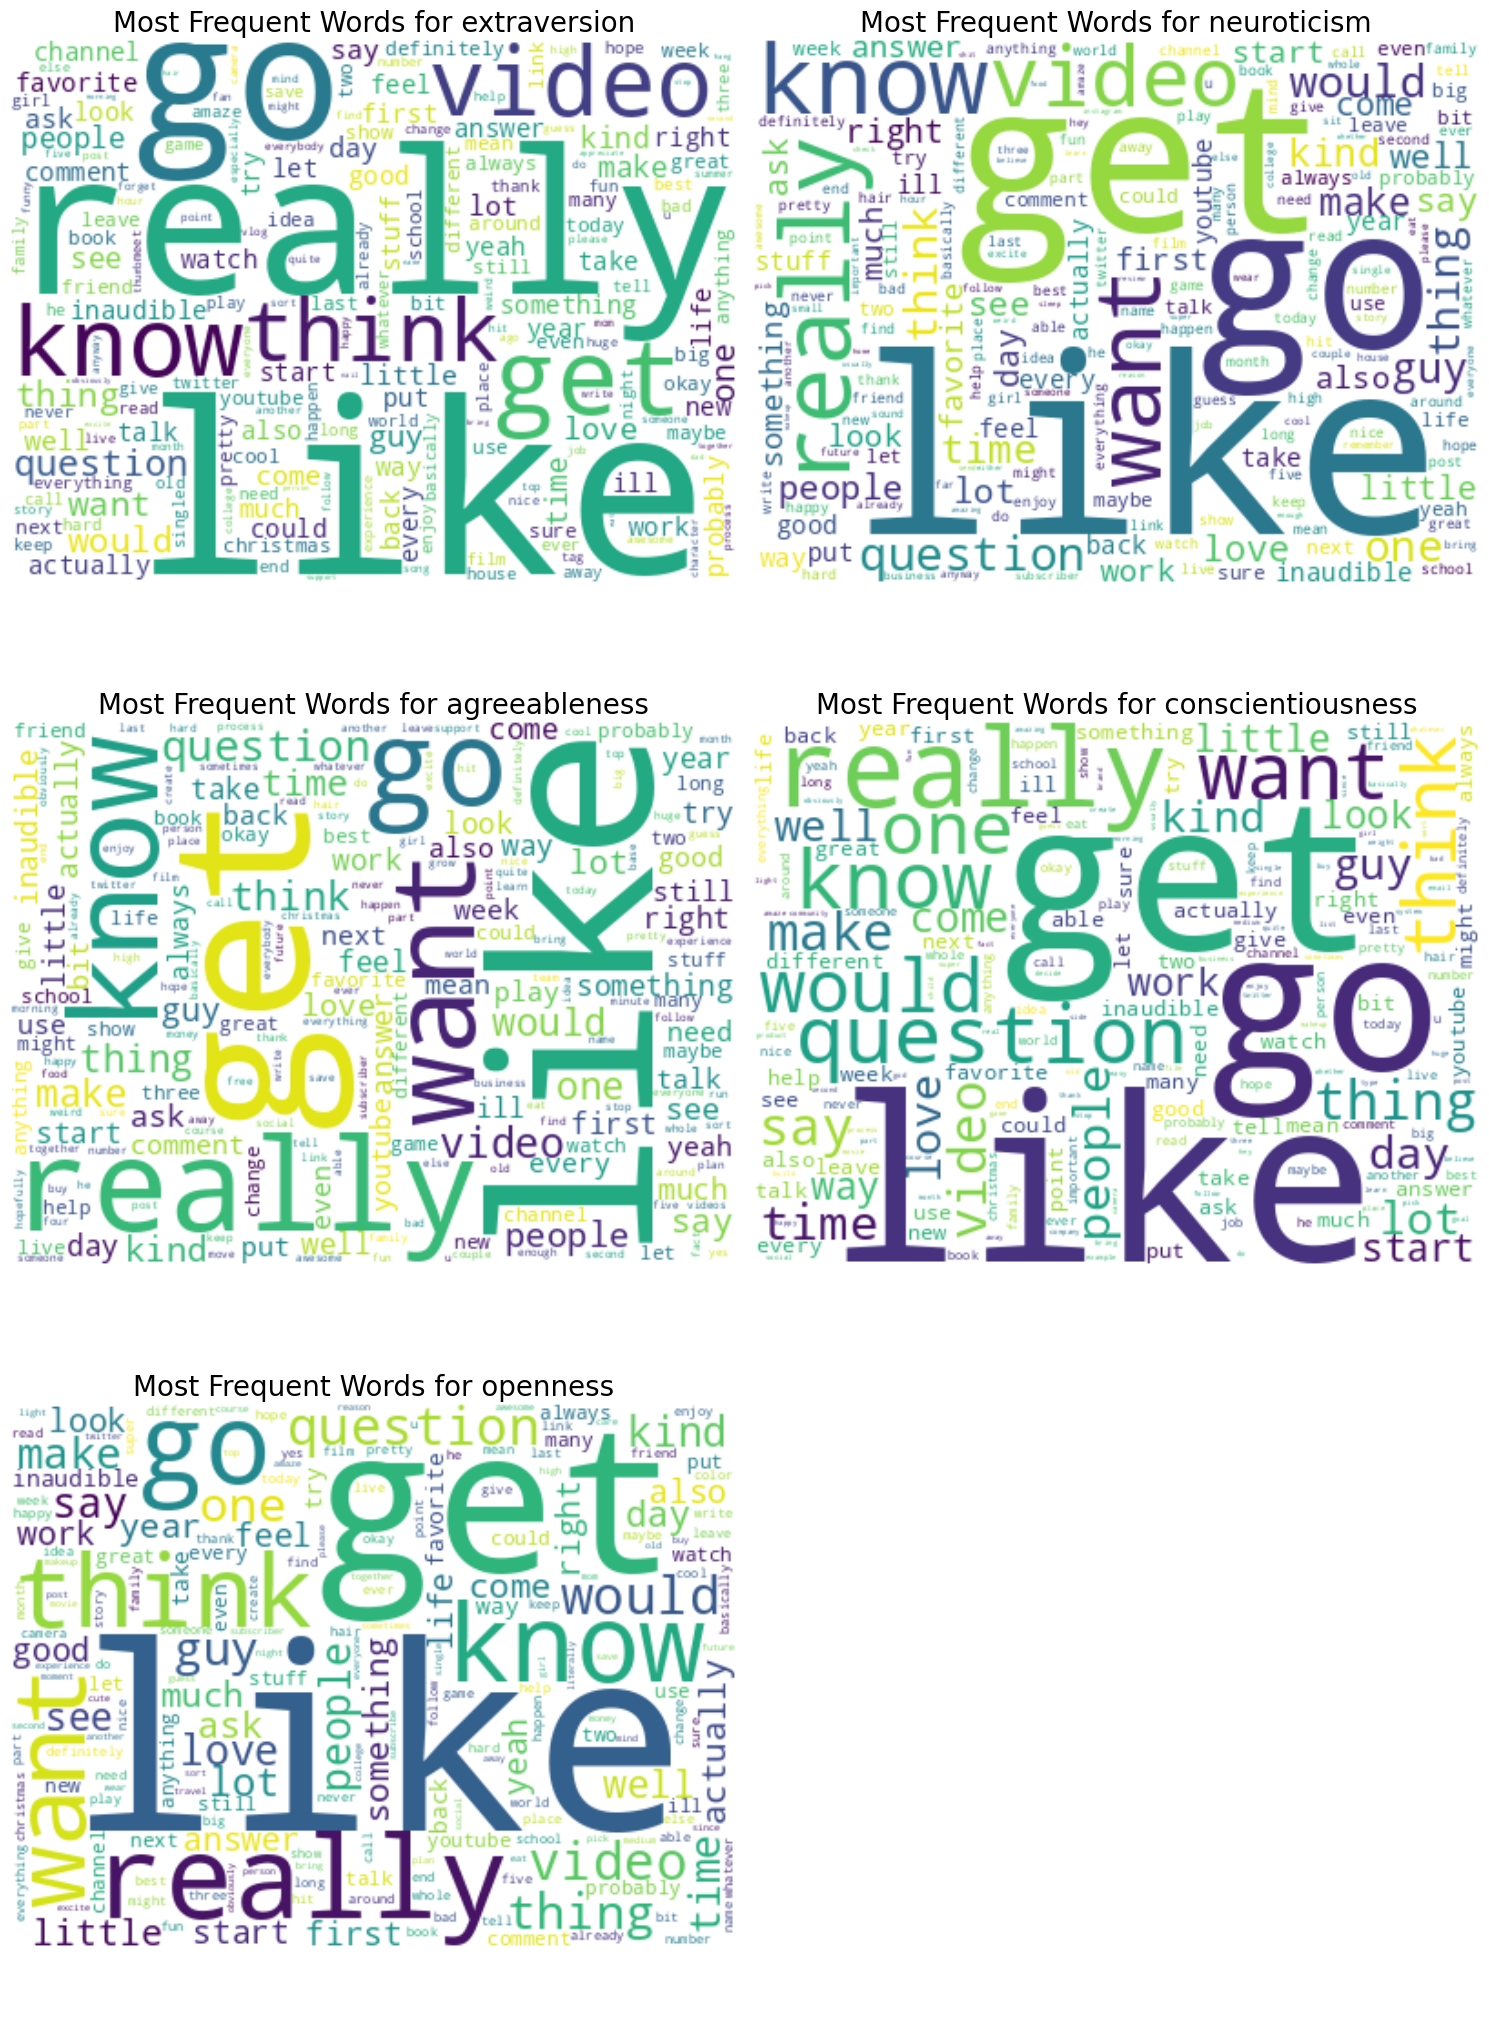

In [ ]:
from wordcloud import WordCloud


personality_traits = ['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']

# Define threshold for personality trait scores
threshold = 0.7

# Initialize an empty dictionary to store word frequencies for each trait
trait_word_frequencies = {trait: Counter() for trait in personality_traits}

# Iterate through the rows of the DataFrame
for index, row in training_df.iterrows():
    text = row['text']
    for trait in personality_traits:
        score = row[trait]
        if score > threshold:
            trait_word_frequencies[trait].update(text)

# Generate subplots for each trait
num_traits = len(personality_traits)
num_rows = (num_traits + 1) // 2
fig, axs = plt.subplots(num_rows, 2, figsize=(15, num_rows * 7))
axs = axs.flatten()

for i, (trait, word_frequencies) in enumerate(trait_word_frequencies.items()):
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(word_frequencies)
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(f'Most Frequent Words for {trait}', fontsize=20)
    axs[i].axis('off')

    # Save the word cloud as an image
    output_filename = f'{trait}_wordcloud.png'
    wordcloud.to_file(output_filename)

# Hide any empty subplots
for i in range(num_traits, num_rows * 2):
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Print top 10 frequent words for each trait
for trait, word_frequencies in trait_word_frequencies.items():
    print(f"Top 10 Frequent Words for {trait}:")
    print(word_frequencies.most_common(10))

Top 10 Frequent Words for extraversion:
[('like', 236), ('really', 163), ('go', 159), ('get', 149), ('know', 121), ('video', 117), ('think', 107), ('question', 102), ('want', 93), ('thing', 90)]
Top 10 Frequent Words for neuroticism:
[('like', 360), ('get', 249), ('go', 229), ('know', 193), ('really', 192), ('want', 170), ('video', 158), ('question', 152), ('would', 142), ('think', 140)]
Top 10 Frequent Words for agreeableness:
[('like', 387), ('get', 275), ('really', 253), ('know', 227), ('go', 218), ('want', 195), ('question', 190), ('video', 174), ('think', 162), ('one', 147)]
Top 10 Frequent Words for conscientiousness:
[('like', 308), ('get', 258), ('go', 227), ('really', 219), ('question', 181), ('know', 178), ('want', 174), ('think', 148), ('would', 147), ('one', 145)]
Top 10 Frequent Words for openness:
[('like', 585), ('get', 341), ('really', 341), ('go', 319), ('know', 298), ('think', 259), ('want', 257), ('question', 236), ('video', 228), ('would', 223)]


# Creating the Embedding

In [ ]:
# !wget -P /content/drive/MyDrive/NLP/ https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

--2023-07-16 13:20:23--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.128, 13.35.7.50, 13.35.7.82, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/NLP/cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  55.3MB/s    in 93s     

2023-07-16 13:21:56 (46.0 MB/s) - ‘/content/drive/MyDrive/NLP/cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [ ]:
import gzip
import shutil

input_file = '/content/drive/MyDrive/NLP/cc.en.300.bin.gz'
output_file = 'cc.en.300.bin'

with gzip.open(input_file, 'rb') as f_in:
    with open(output_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [ ]:
pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199769 sha256=ac8d3fb609da55d7af3939e804bb16e5c190af20138032f0323d44f45c2a1da1
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import fasttext
import fasttext.util
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
fasttext.util.reduce_model(ft, 100)
embedding_dim = ft.get_dimension()
embedding_dim

100

In [ ]:
embedding_dim = 100

In [ ]:
# Create the embedding matrix
embedding_matrix = []
for word, index in vocabulary.items():
    if word in ft.words:
        embedding_matrix.append(ft.get_word_vector(word))
    else:
        # If the word is not found in FastText, initialize with random values
        embedding_matrix.append(np.random.uniform(-0.25, 0.25, embedding_dim))

embedding_matrix = np.array(embedding_matrix)

# Convert text indices to tensors
text_indices_train = torch.tensor(training_df['text_indices'].tolist())

# Create an embedding layer
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)

# Pass the text indices through the embedding layer
embeddings_train = embedding_layer(text_indices_train)

# Set requires_grad to False for the embedding layer parameters
for param in embedding_layer.parameters():
    param.requires_grad = False

# Print the shape of the embeddings
print(embeddings_train.shape)

torch.Size([5987, 32, 100])


In [ ]:
# file_path = '/content/drive/My Drive/NLP/embedding_matrix_impressions.pkl'
# with open(file_path, 'wb') as f:
#     pickle.dump(embedding_matrix, f)

In [ ]:
file_path = '/content/drive/My Drive/NLP/embedding_matrix_impressions.pkl'
with open(file_path, 'rb') as f:
    embedding_matrix = pickle.load(f)

In [ ]:
# del ft

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#TextCNN

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, embedding_layer, num_filters, filter_sizes, hidden_dim, output_dim, dropout_rate):
        super(TextCNN, self).__init__()
        self.embedding = embedding_layer
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_layer.embedding_dim, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, inputs):
        embedded = self.embedding(inputs)
        conved = [nn.functional.relu(conv(embedded.permute(0, 2, 1))).squeeze(2) for conv in self.convs]
        pooled = [nn.functional.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in conved]
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        fc_out = nn.functional.relu(self.fc(cat))
        fc_out = self.dropout(fc_out)
        output = self.output(fc_out)
        return output

In [ ]:
# Define loss function
def mae_loss(outputs, labels):
    batch_size = labels.size(0)
    loss = torch.sum(torch.abs(outputs - labels))
    return (1 / (5 * batch_size)) * loss

In [ ]:
# Set the hyperparameters
vocab_size = len(vocabulary)
num_filters = 100
filter_sizes = [2, 3, 4, 5]
hidden_dim = 100
output_dim = 5
learning_rate = 1e-4
num_epochs = 50
batch_size = 64
dropout = 0.5

In [ ]:
# Create an instance of the TextCNN model
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
model = TextCNN(embedding_layer, num_filters, filter_sizes, hidden_dim, output_dim, dropout)
model.to(device)

TextCNN(
  (embedding): Embedding(9054, 100, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=400, out_features=100, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=100, out_features=5, bias=True)
)

In [ ]:
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=0.005)

In [ ]:
# Create data loaders for training and validation sets
train_data = [(torch.tensor(indices), torch.tensor(labels)) for indices, labels in zip(training_df['text_indices'], training_df[['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']].values)]
valid_data = [(torch.tensor(indices), torch.tensor(labels)) for indices, labels in zip(validation_df['text_indices'], validation_df[['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']].values)]
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)

In [ ]:
training_df.head(2)

text  extraversion  \
0  [he, cut, turn, around, see, end, result, glad...      0.523364   
1  [responsibility, house, organ, give, need, tel...      0.345794   

   neuroticism  agreeableness  conscientiousness  openness  text_size  \
0     0.552083       0.626374           0.601942  0.488889         22   
1     0.375000       0.472527           0.582524  0.366667         17   

                                        text_indices  
0  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3...  
1  [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 25, 3...

In [ ]:
# Print the first few examples from the train_dataset
for i in range(2):
    text, labels = train_data[i]
    print(f"Example {i+1}:")
    print("Text:", text)
    print("Labels:", labels)
    print()

Example 1:
Text: tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  3, 15, 16, 17, 18,
        19, 20, 21, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
Labels: tensor([0.5234, 0.5521, 0.6264, 0.6019, 0.4889], dtype=torch.float64)

Example 2:
Text: tensor([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 25, 33, 34, 35, 36, 37, 38,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
Labels: tensor([0.3458, 0.3750, 0.4725, 0.5825, 0.3667], dtype=torch.float64)



In [ ]:
# Iterate over train_loader and print batch samples
for batch_text, batch_labels in train_loader:
    # Print batch size
    batch_size = len(batch_text)
    print(f"Batch Size: {batch_size}")

    # Print batch samples
    for i in range(batch_size):
        text = batch_text[i]
        labels = batch_labels[i]
        print(f"Example {i+1}:")
        print("Text:", text)
        print("Labels:", labels)
        print("-" * 30)

In [ ]:
# Train the model
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
best_valid_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = mae_loss(outputs, labels)
        acc = 1 - loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = mae_loss(outputs, labels)
            acc = 1 - loss
            valid_loss += loss.item()
            valid_acc += acc.item()

            if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/TextCNN_model.pth')

        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {valid_acc:.4f}")

Epoch 1/50, Training Loss: 0.2643, Validation Loss: 0.1258, Training Accuracy: 0.7357, Validation Accuracy: 0.8742
Epoch 2/50, Training Loss: 0.1750, Validation Loss: 0.1207, Training Accuracy: 0.8250, Validation Accuracy: 0.8793
Epoch 3/50, Training Loss: 0.1668, Validation Loss: 0.1188, Training Accuracy: 0.8332, Validation Accuracy: 0.8812
Epoch 4/50, Training Loss: 0.1618, Validation Loss: 0.1213, Training Accuracy: 0.8382, Validation Accuracy: 0.8787
Epoch 5/50, Training Loss: 0.1571, Validation Loss: 0.1167, Training Accuracy: 0.8429, Validation Accuracy: 0.8833
Epoch 6/50, Training Loss: 0.1529, Validation Loss: 0.1199, Training Accuracy: 0.8471, Validation Accuracy: 0.8801
Epoch 7/50, Training Loss: 0.1478, Validation Loss: 0.1181, Training Accuracy: 0.8522, Validation Accuracy: 0.8819
Epoch 8/50, Training Loss: 0.1461, Validation Loss: 0.1175, Training Accuracy: 0.8539, Validation Accuracy: 0.8825
Epoch 9/50, Training Loss: 0.1448, Validation Loss: 0.1183, Training Accuracy: 0

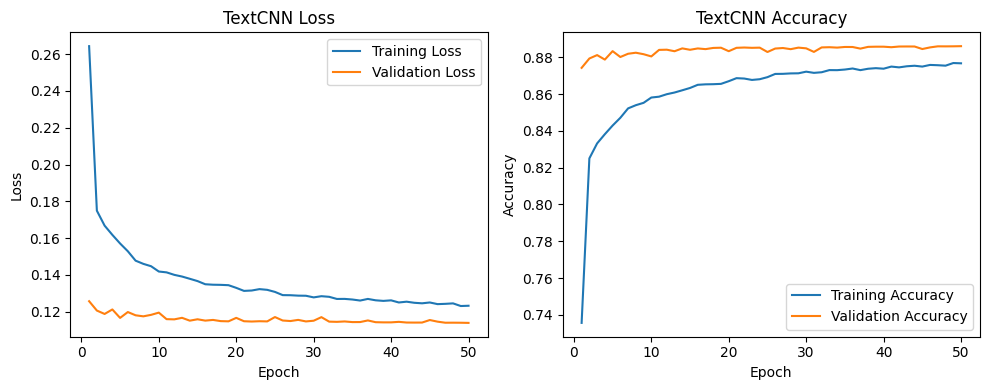

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(range(1, num_epochs+1), train_losses, label='Training Loss')
axs[0].plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('TextCNN Loss')
axs[0].legend()

axs[1].plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
axs[1].plot(range(1, num_epochs+1), valid_accs, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('TextCNN Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
model = TextCNN(embedding_layer, num_filters, filter_sizes, hidden_dim, output_dim, dropout)
model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/TextCNN_model.pth'))

<All keys matched successfully>

In [ ]:
# Convert text indices of the test set to tensors
text_indices_test = torch.tensor(test_df['text_indices'].tolist())

# Create a data loader for the test set
test_data = [(torch.tensor(indices), torch.tensor(labels)) for indices, labels in zip(test_df['text_indices'], test_df[['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']].values)]
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = mae_loss(outputs, labels)
        acc = 1 - loss

        test_loss += loss.item()
        test_acc += acc.item()

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1182, Test Accuracy: 0.8818


In [ ]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 1086405
Trainable parameters: 181005


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable Parameters in {name}: {param.numel():,}")

print("\nDetailed breakdown of parameters for each layer:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,}")

Trainable Parameters in convs.0.weight: 20,000
Trainable Parameters in convs.0.bias: 100
Trainable Parameters in convs.1.weight: 30,000
Trainable Parameters in convs.1.bias: 100
Trainable Parameters in convs.2.weight: 40,000
Trainable Parameters in convs.2.bias: 100
Trainable Parameters in convs.3.weight: 50,000
Trainable Parameters in convs.3.bias: 100
Trainable Parameters in fc.weight: 40,000
Trainable Parameters in fc.bias: 100
Trainable Parameters in output.weight: 500
Trainable Parameters in output.bias: 5

Detailed breakdown of parameters for each layer:
embedding.weight: 905,400
convs.0.weight: 20,000
convs.0.bias: 100
convs.1.weight: 30,000
convs.1.bias: 100
convs.2.weight: 40,000
convs.2.bias: 100
convs.3.weight: 50,000
convs.3.bias: 100
fc.weight: 40,000
fc.bias: 100
output.weight: 500
output.bias: 5


#DPCNN

In [ ]:
# Define the DPCNN model
class DPCNN(nn.Module):
    def __init__(self, embedding_layer, num_filters, filter_sizes, hidden_dim, output_dim, dropout_rate):
        super(DPCNN, self).__init__()
        self.embedding = embedding_layer
        self.conv_blocks = nn.ModuleList()

        for filter_size in filter_sizes:
            conv_block = nn.Sequential(
                nn.Conv1d(embedding_layer.embedding_dim, num_filters, kernel_size=filter_size, dilation=1),
                nn.ReLU(),
                nn.Conv1d(num_filters, num_filters, kernel_size=filter_size, padding=filter_size - 1),
                nn.ReLU()
            )
            self.conv_blocks.append(conv_block)

        self.pool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, inputs):
        embedded = self.embedding(inputs).permute(0, 2, 1)
        conv_outputs = []

        for conv_block in self.conv_blocks:
            x = conv_block(embedded)
            x = self.pool(x)
            conv_outputs.append(x)

        x = torch.cat(conv_outputs, dim=1)
        x = torch.mean(x, dim=2)
        x = self.fc(x)
        x = self.dropout(x)
        output = self.output(x)
        return output

In [ ]:
# Set the hyperparameters
num_filters = 100
filter_sizes = [2, 3, 4, 5]
hidden_dim = 100
output_dim = 5
learning_rate = 1e-4
num_epochs = 50
dropout = 0.5

In [ ]:
# Create an instance of the DPCNN model
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
model = DPCNN(embedding_layer, num_filters, filter_sizes, hidden_dim, output_dim, dropout)
model.to(device)

DPCNN(
  (embedding): Embedding(9054, 100, padding_idx=0)
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(100, 100, kernel_size=(2,), stride=(1,), padding=(1,))
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(2,))
      (3): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,), padding=(3,))
      (3): ReLU()
    )
    (3): Sequential(
      (0): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(4,))
      (3): ReLU()
    )
  )
  (pool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=400, out_features

In [ ]:
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=0.005)

In [ ]:
# Train the model
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
best_valid_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = mae_loss(outputs, labels)
        acc = 1 - loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = mae_loss(outputs, labels)
            acc = 1 - loss
            valid_loss += loss.item()
            valid_acc += acc.item()

            if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/DPCNN_model.pth')

        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {valid_acc:.4f}")

Epoch 1/50, Training Loss: 0.2541, Validation Loss: 0.1234, Training Accuracy: 0.7459, Validation Accuracy: 0.8766
Epoch 2/50, Training Loss: 0.1466, Validation Loss: 0.1179, Training Accuracy: 0.8534, Validation Accuracy: 0.8821
Epoch 3/50, Training Loss: 0.1412, Validation Loss: 0.1179, Training Accuracy: 0.8588, Validation Accuracy: 0.8821
Epoch 4/50, Training Loss: 0.1374, Validation Loss: 0.1152, Training Accuracy: 0.8626, Validation Accuracy: 0.8848
Epoch 5/50, Training Loss: 0.1359, Validation Loss: 0.1159, Training Accuracy: 0.8641, Validation Accuracy: 0.8841
Epoch 6/50, Training Loss: 0.1344, Validation Loss: 0.1161, Training Accuracy: 0.8656, Validation Accuracy: 0.8839
Epoch 7/50, Training Loss: 0.1322, Validation Loss: 0.1146, Training Accuracy: 0.8678, Validation Accuracy: 0.8854
Epoch 8/50, Training Loss: 0.1315, Validation Loss: 0.1134, Training Accuracy: 0.8685, Validation Accuracy: 0.8866
Epoch 9/50, Training Loss: 0.1312, Validation Loss: 0.1146, Training Accuracy: 0

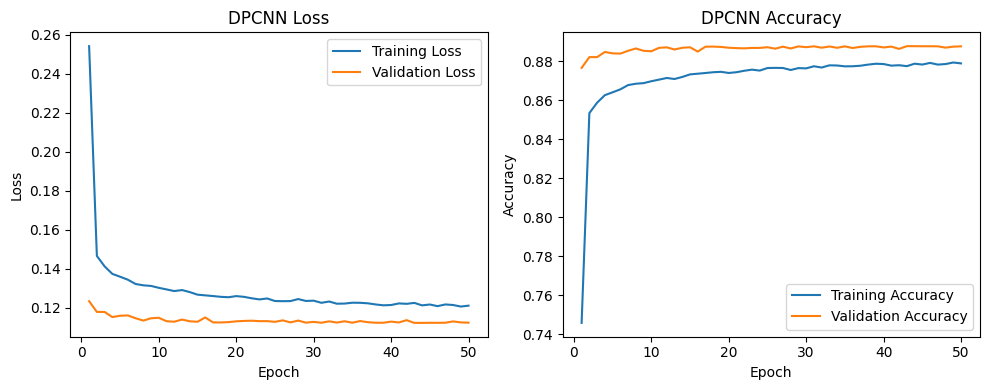

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(range(1, num_epochs+1), train_losses, label='Training Loss')
axs[0].plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('DPCNN Loss')
axs[0].legend()

axs[1].plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
axs[1].plot(range(1, num_epochs+1), valid_accs, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('DPCNN Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
model = DPCNN(embedding_layer, num_filters, filter_sizes, hidden_dim, output_dim, dropout)
model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/DPCNN_model.pth'))

<All keys matched successfully>

In [ ]:
# Convert text indices of the test set to tensors
text_indices_test = torch.tensor(test_df['text_indices'].tolist())

# Create a data loader for the test set
test_data = [(torch.tensor(indices), torch.tensor(labels)) for indices, labels in zip(test_df['text_indices'], test_df[['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']].values)]
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = mae_loss(outputs, labels)
        acc = 1 - loss

        test_loss += loss.item()
        test_acc += acc.item()

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1163, Test Accuracy: 0.8837


In [ ]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 1226805
Trainable parameters: 321405


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable Parameters in {name}: {param.numel():,}")

print("\nDetailed breakdown of parameters for each layer:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,}")

Trainable Parameters in conv_blocks.0.0.weight: 20,000
Trainable Parameters in conv_blocks.0.0.bias: 100
Trainable Parameters in conv_blocks.0.2.weight: 20,000
Trainable Parameters in conv_blocks.0.2.bias: 100
Trainable Parameters in conv_blocks.1.0.weight: 30,000
Trainable Parameters in conv_blocks.1.0.bias: 100
Trainable Parameters in conv_blocks.1.2.weight: 30,000
Trainable Parameters in conv_blocks.1.2.bias: 100
Trainable Parameters in conv_blocks.2.0.weight: 40,000
Trainable Parameters in conv_blocks.2.0.bias: 100
Trainable Parameters in conv_blocks.2.2.weight: 40,000
Trainable Parameters in conv_blocks.2.2.bias: 100
Trainable Parameters in conv_blocks.3.0.weight: 50,000
Trainable Parameters in conv_blocks.3.0.bias: 100
Trainable Parameters in conv_blocks.3.2.weight: 50,000
Trainable Parameters in conv_blocks.3.2.bias: 100
Trainable Parameters in fc.weight: 40,000
Trainable Parameters in fc.bias: 100
Trainable Parameters in output.weight: 500
Trainable Parameters in output.bias: 5

#RNN

In [ ]:
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, output_dim, dropout_rate):
        super(RNN, self).__init__()
        self.embedding = embedding_layer
        self.rnn = nn.RNN(embedding_layer.embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, inputs):
        embedded = self.embedding(inputs)
        output, _ = self.rnn(embedded)
        output = self.dropout(output[:, -1, :])  # Use the final hidden state
        output = self.fc(output)
        return output

In [ ]:
# Set the hyperparameters
hidden_dim = 100
output_dim = 5
learning_rate = 1e-4
num_epochs = 50
dropout = 0.5

In [ ]:
# Create an instance of the RNN model
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
model = RNN(embedding_layer, hidden_dim, output_dim, dropout)
model.to(device)

RNN(
  (embedding): Embedding(9054, 100, padding_idx=0)
  (rnn): RNN(100, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=0.005)

In [ ]:
# Train the model
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
best_valid_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = mae_loss(outputs, labels)
        acc = 1 - loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = mae_loss(outputs, labels)
            acc = 1 - loss
            valid_loss += loss.item()
            valid_acc += acc.item()

            if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/RNN_model.pth')

        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {valid_acc:.4f}")

Epoch 1/50, Training Loss: 0.2673, Validation Loss: 0.1244, Training Accuracy: 0.7327, Validation Accuracy: 0.8756
Epoch 2/50, Training Loss: 0.1613, Validation Loss: 0.1193, Training Accuracy: 0.8387, Validation Accuracy: 0.8807
Epoch 3/50, Training Loss: 0.1515, Validation Loss: 0.1193, Training Accuracy: 0.8485, Validation Accuracy: 0.8807
Epoch 4/50, Training Loss: 0.1451, Validation Loss: 0.1181, Training Accuracy: 0.8549, Validation Accuracy: 0.8819
Epoch 5/50, Training Loss: 0.1426, Validation Loss: 0.1194, Training Accuracy: 0.8574, Validation Accuracy: 0.8806
Epoch 6/50, Training Loss: 0.1402, Validation Loss: 0.1192, Training Accuracy: 0.8598, Validation Accuracy: 0.8808
Epoch 7/50, Training Loss: 0.1405, Validation Loss: 0.1175, Training Accuracy: 0.8595, Validation Accuracy: 0.8825
Epoch 8/50, Training Loss: 0.1383, Validation Loss: 0.1173, Training Accuracy: 0.8617, Validation Accuracy: 0.8827
Epoch 9/50, Training Loss: 0.1371, Validation Loss: 0.1175, Training Accuracy: 0

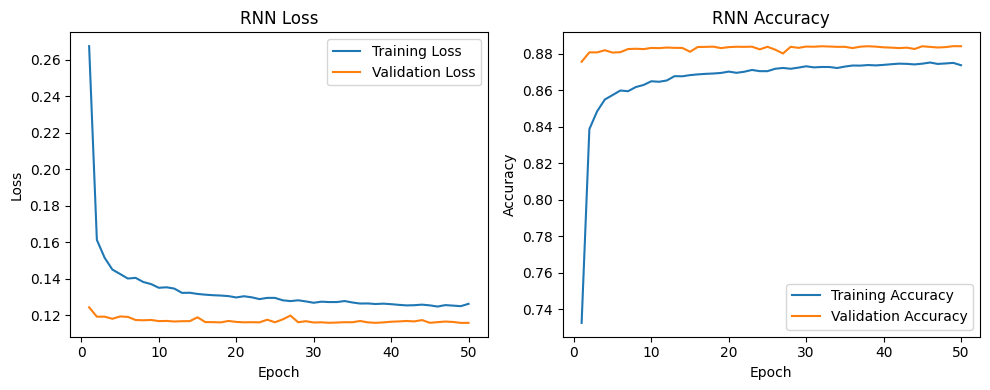

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(range(1, num_epochs+1), train_losses, label='Training Loss')
axs[0].plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('RNN Loss')
axs[0].legend()

axs[1].plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
axs[1].plot(range(1, num_epochs+1), valid_accs, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('RNN Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
model = RNN(embedding_layer, hidden_dim, output_dim, dropout)
model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/RNN_model.pth'))

<All keys matched successfully>

In [ ]:
# Convert text indices of the test set to tensors
text_indices_test = torch.tensor(test_df['text_indices'].tolist())

# Create a data loader for the test set
test_data = [(torch.tensor(indices), torch.tensor(labels)) for indices, labels in zip(test_df['text_indices'], test_df[['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']].values)]
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = mae_loss(outputs, labels)
        acc = 1 - loss

        test_loss += loss.item()
        test_acc += acc.item()

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1210, Test Accuracy: 0.8790


In [ ]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 926105
Trainable parameters: 20705


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable Parameters in {name}: {param.numel():,}")

print("\nDetailed breakdown of parameters for each layer:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,}")

Trainable Parameters in rnn.weight_ih_l0: 10,000
Trainable Parameters in rnn.weight_hh_l0: 10,000
Trainable Parameters in rnn.bias_ih_l0: 100
Trainable Parameters in rnn.bias_hh_l0: 100
Trainable Parameters in fc.weight: 500
Trainable Parameters in fc.bias: 5

Detailed breakdown of parameters for each layer:
embedding.weight: 905,400
rnn.weight_ih_l0: 10,000
rnn.weight_hh_l0: 10,000
rnn.bias_ih_l0: 100
rnn.bias_hh_l0: 100
fc.weight: 500
fc.bias: 5


#LSTM

In [ ]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, output_dim, dropout_rate):
        super(LSTM, self).__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(embedding_layer.embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, inputs):
        embedded = self.embedding(inputs)
        output, _ = self.lstm(embedded)
        output = self.dropout(output[:, -1, :])  # Use the final hidden state
        output = self.fc(output)
        return output

In [ ]:
# Set the hyperparameters
hidden_dim = 100
output_dim = 5
learning_rate = 1e-4
num_epochs = 50
dropout = 0.5

In [ ]:
# Create an instance of the LSTM model
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
model = LSTM(embedding_layer, hidden_dim, output_dim, dropout)
model.to(device)

LSTM(
  (embedding): Embedding(9054, 100, padding_idx=0)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=0.005)

In [ ]:
# Train the model
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
best_valid_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = mae_loss(outputs, labels)
        acc = 1 - loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = mae_loss(outputs, labels)
            acc = 1 - loss
            valid_loss += loss.item()
            valid_acc += acc.item()

            if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/LSTM_model.pth')

        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {valid_acc:.4f}")

Epoch 1/50, Training Loss: 0.3209, Validation Loss: 0.1291, Training Accuracy: 0.6791, Validation Accuracy: 0.8709
Epoch 2/50, Training Loss: 0.1559, Validation Loss: 0.1274, Training Accuracy: 0.8441, Validation Accuracy: 0.8726
Epoch 3/50, Training Loss: 0.1487, Validation Loss: 0.1224, Training Accuracy: 0.8513, Validation Accuracy: 0.8776
Epoch 4/50, Training Loss: 0.1445, Validation Loss: 0.1210, Training Accuracy: 0.8555, Validation Accuracy: 0.8790
Epoch 5/50, Training Loss: 0.1428, Validation Loss: 0.1210, Training Accuracy: 0.8572, Validation Accuracy: 0.8790
Epoch 6/50, Training Loss: 0.1403, Validation Loss: 0.1209, Training Accuracy: 0.8597, Validation Accuracy: 0.8791
Epoch 7/50, Training Loss: 0.1402, Validation Loss: 0.1204, Training Accuracy: 0.8598, Validation Accuracy: 0.8796
Epoch 8/50, Training Loss: 0.1369, Validation Loss: 0.1196, Training Accuracy: 0.8631, Validation Accuracy: 0.8804
Epoch 9/50, Training Loss: 0.1361, Validation Loss: 0.1197, Training Accuracy: 0

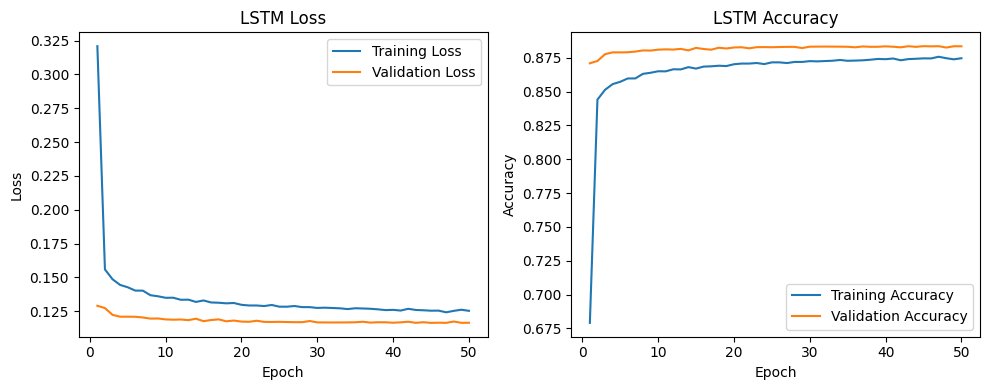

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(range(1, num_epochs+1), train_losses, label='Training Loss')
axs[0].plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('LSTM Loss')
axs[0].legend()

axs[1].plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
axs[1].plot(range(1, num_epochs+1), valid_accs, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('LSTM Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
model = LSTM(embedding_layer, hidden_dim, output_dim, dropout)
model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/LSTM_model.pth'))

<All keys matched successfully>

In [ ]:
# Convert text indices of the test set to tensors
text_indices_test = torch.tensor(test_df['text_indices'].tolist())

# Create a data loader for the test set
test_data = [(torch.tensor(indices), torch.tensor(labels)) for indices, labels in zip(test_df['text_indices'], test_df[['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']].values)]
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = mae_loss(outputs, labels)
        acc = 1 - loss

        test_loss += loss.item()
        test_acc += acc.item()

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1198, Test Accuracy: 0.8802


In [ ]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 986705
Trainable parameters: 81305


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable Parameters in {name}: {param.numel():,}")

print("\nDetailed breakdown of parameters for each layer:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,}")

Trainable Parameters in lstm.weight_ih_l0: 40,000
Trainable Parameters in lstm.weight_hh_l0: 40,000
Trainable Parameters in lstm.bias_ih_l0: 400
Trainable Parameters in lstm.bias_hh_l0: 400
Trainable Parameters in fc.weight: 500
Trainable Parameters in fc.bias: 5

Detailed breakdown of parameters for each layer:
embedding.weight: 905,400
lstm.weight_ih_l0: 40,000
lstm.weight_hh_l0: 40,000
lstm.bias_ih_l0: 400
lstm.bias_hh_l0: 400
fc.weight: 500
fc.bias: 5


#Bi-LSTM

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, output_dim, dropout):
        super(BiLSTM, self).__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, inputs):
        embedded = self.embedding(inputs)
        outputs, _ = self.lstm(embedded)
        outputs = self.dropout(outputs)
        outputs = torch.mean(outputs, dim=1)
        outputs = self.fc(outputs)
        return outputs

In [ ]:
# Set the hyperparameters
hidden_dim = 100
output_dim = 5
learning_rate = 1e-4
num_epochs = 50
dropout = 0.5

In [ ]:
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
model = BiLSTM(embedding_layer, hidden_dim, output_dim, dropout)
model.to(device)

BiLSTM(
  (embedding): Embedding(9054, 100, padding_idx=0)
  (lstm): LSTM(100, 100, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=5, bias=True)
)

In [ ]:
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=0.005)

In [ ]:
# Train the model
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
best_valid_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = mae_loss(outputs, labels)
        acc = 1 - loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = mae_loss(outputs, labels)
            acc = 1 - loss
            valid_loss += loss.item()
            valid_acc += acc.item()

            if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/BiLSTM_model.pth')

        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {valid_acc:.4f}")

Epoch 1/50, Training Loss: 0.3443, Validation Loss: 0.1388, Training Accuracy: 0.6557, Validation Accuracy: 0.8612
Epoch 2/50, Training Loss: 0.1335, Validation Loss: 0.1285, Training Accuracy: 0.8665, Validation Accuracy: 0.8715
Epoch 3/50, Training Loss: 0.1309, Validation Loss: 0.1274, Training Accuracy: 0.8691, Validation Accuracy: 0.8726
Epoch 4/50, Training Loss: 0.1297, Validation Loss: 0.1256, Training Accuracy: 0.8703, Validation Accuracy: 0.8744
Epoch 5/50, Training Loss: 0.1283, Validation Loss: 0.1245, Training Accuracy: 0.8717, Validation Accuracy: 0.8755
Epoch 6/50, Training Loss: 0.1273, Validation Loss: 0.1242, Training Accuracy: 0.8727, Validation Accuracy: 0.8758
Epoch 7/50, Training Loss: 0.1272, Validation Loss: 0.1229, Training Accuracy: 0.8728, Validation Accuracy: 0.8771
Epoch 8/50, Training Loss: 0.1257, Validation Loss: 0.1234, Training Accuracy: 0.8743, Validation Accuracy: 0.8766
Epoch 9/50, Training Loss: 0.1257, Validation Loss: 0.1216, Training Accuracy: 0

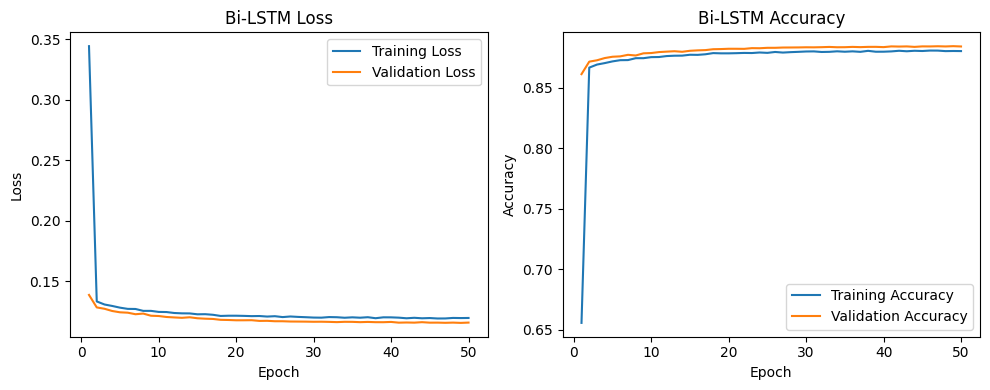

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(range(1, num_epochs+1), train_losses, label='Training Loss')
axs[0].plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Bi-LSTM Loss')
axs[0].legend()

axs[1].plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
axs[1].plot(range(1, num_epochs+1), valid_accs, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Bi-LSTM Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
model = BiLSTM(embedding_layer, hidden_dim, output_dim, dropout)
model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/BiLSTM_model.pth'))

<All keys matched successfully>

In [ ]:
# Convert text indices of the test set to tensors
text_indices_test = torch.tensor(test_df['text_indices'].tolist())

# Create a data loader for the test set
test_data = [(torch.tensor(indices), torch.tensor(labels)) for indices, labels in zip(test_df['text_indices'], test_df[['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']].values)]
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = mae_loss(outputs, labels)
        acc = 1 - loss

        test_loss += loss.item()
        test_acc += acc.item()

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1196, Test Accuracy: 0.8804


In [ ]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 1068005
Trainable parameters: 162605


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable Parameters in {name}: {param.numel():,}")

print("\nDetailed breakdown of parameters for each layer:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,}")

Trainable Parameters in lstm.weight_ih_l0: 40,000
Trainable Parameters in lstm.weight_hh_l0: 40,000
Trainable Parameters in lstm.bias_ih_l0: 400
Trainable Parameters in lstm.bias_hh_l0: 400
Trainable Parameters in lstm.weight_ih_l0_reverse: 40,000
Trainable Parameters in lstm.weight_hh_l0_reverse: 40,000
Trainable Parameters in lstm.bias_ih_l0_reverse: 400
Trainable Parameters in lstm.bias_hh_l0_reverse: 400
Trainable Parameters in fc.weight: 1,000
Trainable Parameters in fc.bias: 5

Detailed breakdown of parameters for each layer:
embedding.weight: 905,400
lstm.weight_ih_l0: 40,000
lstm.weight_hh_l0: 40,000
lstm.bias_ih_l0: 400
lstm.bias_hh_l0: 400
lstm.weight_ih_l0_reverse: 40,000
lstm.weight_hh_l0_reverse: 40,000
lstm.bias_ih_l0_reverse: 400
lstm.bias_hh_l0_reverse: 400
fc.weight: 1,000
fc.bias: 5


# Bi-LSTM with Attention

In [ ]:
class BiLSTM_Attention(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, output_dim, dropout_rate):
        super(BiLSTM_Attention, self).__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(embedding_layer.embedding_dim, hidden_dim, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, inputs):
        embedded = self.embedding(inputs)
        outputs, _ = self.lstm(embedded)

        attention_scores = self.attention(outputs).squeeze(2)
        attention_weights = nn.functional.softmax(attention_scores, dim=1).unsqueeze(2)
        weighted_sum = torch.sum(outputs * attention_weights, dim=1)

        fc_out = nn.functional.relu(self.fc(weighted_sum))
        fc_out = self.dropout(fc_out)
        output = self.output(fc_out)
        return output

In [ ]:
# Set the hyperparameters
hidden_dim = 100
output_dim = 5
learning_rate = 1e-4
num_epochs = 50
dropout = 0.5

In [ ]:
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
model = BiLSTM_Attention(embedding_layer, hidden_dim, output_dim, dropout)
model.to(device)

BiLSTM_Attention(
  (embedding): Embedding(9054, 100, padding_idx=0)
  (lstm): LSTM(100, 100, bidirectional=True)
  (attention): Linear(in_features=200, out_features=1, bias=True)
  (fc): Linear(in_features=200, out_features=100, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=100, out_features=5, bias=True)
)

In [ ]:
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=0.005)

In [ ]:
# Train the model
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
best_valid_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = mae_loss(outputs, labels)
        acc = 1 - loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = mae_loss(outputs, labels)
            acc = 1 - loss
            valid_loss += loss.item()
            valid_acc += acc.item()

            if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/BiLSTM_Attention_model.pth')

        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {valid_acc:.4f}")

Epoch 1/50, Training Loss: 0.4386, Validation Loss: 0.2684, Training Accuracy: 0.5614, Validation Accuracy: 0.7316
Epoch 2/50, Training Loss: 0.1874, Validation Loss: 0.1318, Training Accuracy: 0.8126, Validation Accuracy: 0.8682
Epoch 3/50, Training Loss: 0.1663, Validation Loss: 0.1281, Training Accuracy: 0.8337, Validation Accuracy: 0.8719
Epoch 4/50, Training Loss: 0.1580, Validation Loss: 0.1241, Training Accuracy: 0.8420, Validation Accuracy: 0.8759
Epoch 5/50, Training Loss: 0.1540, Validation Loss: 0.1251, Training Accuracy: 0.8460, Validation Accuracy: 0.8749
Epoch 6/50, Training Loss: 0.1499, Validation Loss: 0.1205, Training Accuracy: 0.8501, Validation Accuracy: 0.8795
Epoch 7/50, Training Loss: 0.1476, Validation Loss: 0.1231, Training Accuracy: 0.8524, Validation Accuracy: 0.8769
Epoch 8/50, Training Loss: 0.1431, Validation Loss: 0.1215, Training Accuracy: 0.8569, Validation Accuracy: 0.8785
Epoch 9/50, Training Loss: 0.1435, Validation Loss: 0.1193, Training Accuracy: 0

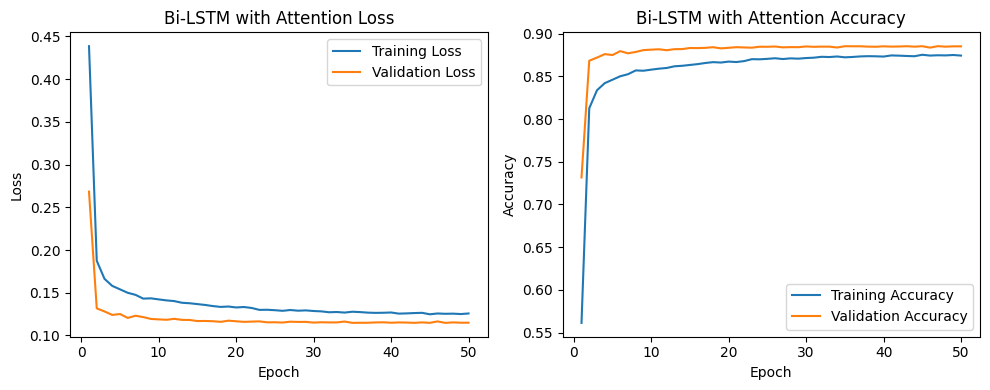

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(range(1, num_epochs+1), train_losses, label='Training Loss')
axs[0].plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Bi-LSTM with Attention Loss')
axs[0].legend()

axs[1].plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
axs[1].plot(range(1, num_epochs+1), valid_accs, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Bi-LSTM with Attention Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
model = BiLSTM_Attention(embedding_layer, hidden_dim, output_dim, dropout)
model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/BiLSTM_Attention_model.pth'))

<All keys matched successfully>

In [ ]:
# Convert text indices of the test set to tensors
text_indices_test = torch.tensor(test_df['text_indices'].tolist())

# Create a data loader for the test set
test_data = [(torch.tensor(indices), torch.tensor(labels)) for indices, labels in zip(test_df['text_indices'], test_df[['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']].values)]
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = mae_loss(outputs, labels)
        acc = 1 - loss

        test_loss += loss.item()
        test_acc += acc.item()

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1181, Test Accuracy: 0.8819


In [ ]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 1087806
Trainable parameters: 182406


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable Parameters in {name}: {param.numel():,}")

print("\nDetailed breakdown of parameters for each layer:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,}")

Trainable Parameters in lstm.weight_ih_l0: 40,000
Trainable Parameters in lstm.weight_hh_l0: 40,000
Trainable Parameters in lstm.bias_ih_l0: 400
Trainable Parameters in lstm.bias_hh_l0: 400
Trainable Parameters in lstm.weight_ih_l0_reverse: 40,000
Trainable Parameters in lstm.weight_hh_l0_reverse: 40,000
Trainable Parameters in lstm.bias_ih_l0_reverse: 400
Trainable Parameters in lstm.bias_hh_l0_reverse: 400
Trainable Parameters in attention.weight: 200
Trainable Parameters in attention.bias: 1
Trainable Parameters in fc.weight: 20,000
Trainable Parameters in fc.bias: 100
Trainable Parameters in output.weight: 500
Trainable Parameters in output.bias: 5

Detailed breakdown of parameters for each layer:
embedding.weight: 905,400
lstm.weight_ih_l0: 40,000
lstm.weight_hh_l0: 40,000
lstm.bias_ih_l0: 400
lstm.bias_hh_l0: 400
lstm.weight_ih_l0_reverse: 40,000
lstm.weight_hh_l0_reverse: 40,000
lstm.bias_ih_l0_reverse: 400
lstm.bias_hh_l0_reverse: 400
attention.weight: 200
attention.bias: 1
fc.

#Hierarchical Attention Network (HAN)

In [ ]:
class HAN(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, output_dim, dropout):
        super(HAN, self).__init__()
        self.embedding = embedding_layer
        self.word_rnn = nn.GRU(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.word_attention = nn.Linear(hidden_dim * 2, 1)
        self.sentence_rnn = nn.GRU(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        self.sentence_attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, inputs):
        batch_size, max_sent_len = inputs.size()

        # Reshape inputs to combine sentence dimension
        combined_inputs = inputs.view(batch_size * max_sent_len, -1)

        # Word-level attention
        embedded = self.embedding(combined_inputs)
        word_outputs, _ = self.word_rnn(embedded)
        word_attention_weights = F.softmax(self.word_attention(word_outputs), dim=1)
        word_representation = torch.sum(word_attention_weights * word_outputs, dim=1)

        # Reshape word representations back to sentence level
        sentence_representation = word_representation.view(batch_size, max_sent_len, -1)

        # Sentence-level attention
        sentence_outputs, _ = self.sentence_rnn(sentence_representation)
        sentence_attention_weights = F.softmax(self.sentence_attention(sentence_outputs), dim=1)
        final_representation = torch.sum(sentence_attention_weights * sentence_outputs, dim=1)

        final_representation = self.dropout(final_representation)
        outputs = self.fc(final_representation)
        return outputs

In [ ]:
# Set the hyperparameters
hidden_dim = 100
output_dim = 5
learning_rate = 1e-4
num_epochs = 50
dropout = 0.5

In [ ]:
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
model = HAN(embedding_layer, hidden_dim, output_dim, dropout)
model.to(device)

HAN(
  (embedding): Embedding(9054, 100, padding_idx=0)
  (word_rnn): GRU(100, 100, batch_first=True, bidirectional=True)
  (word_attention): Linear(in_features=200, out_features=1, bias=True)
  (sentence_rnn): GRU(200, 100, batch_first=True, bidirectional=True)
  (sentence_attention): Linear(in_features=200, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=5, bias=True)
)

In [ ]:
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=0.005)

In [ ]:
# Train the model
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
best_valid_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = mae_loss(outputs, labels)
        acc = 1 - loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = mae_loss(outputs, labels)
            acc = 1 - loss
            valid_loss += loss.item()
            valid_acc += acc.item()

            if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/HAN_model.pth')

        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {valid_acc:.4f}")

Epoch 1/50, Training Loss: 0.2890, Validation Loss: 0.1305, Training Accuracy: 0.7110, Validation Accuracy: 0.8695
Epoch 2/50, Training Loss: 0.1464, Validation Loss: 0.1197, Training Accuracy: 0.8536, Validation Accuracy: 0.8803
Epoch 3/50, Training Loss: 0.1368, Validation Loss: 0.1160, Training Accuracy: 0.8632, Validation Accuracy: 0.8840
Epoch 4/50, Training Loss: 0.1327, Validation Loss: 0.1154, Training Accuracy: 0.8673, Validation Accuracy: 0.8846
Epoch 5/50, Training Loss: 0.1307, Validation Loss: 0.1156, Training Accuracy: 0.8693, Validation Accuracy: 0.8844
Epoch 6/50, Training Loss: 0.1298, Validation Loss: 0.1135, Training Accuracy: 0.8702, Validation Accuracy: 0.8865
Epoch 7/50, Training Loss: 0.1285, Validation Loss: 0.1135, Training Accuracy: 0.8715, Validation Accuracy: 0.8865
Epoch 8/50, Training Loss: 0.1271, Validation Loss: 0.1139, Training Accuracy: 0.8729, Validation Accuracy: 0.8861
Epoch 9/50, Training Loss: 0.1270, Validation Loss: 0.1136, Training Accuracy: 0

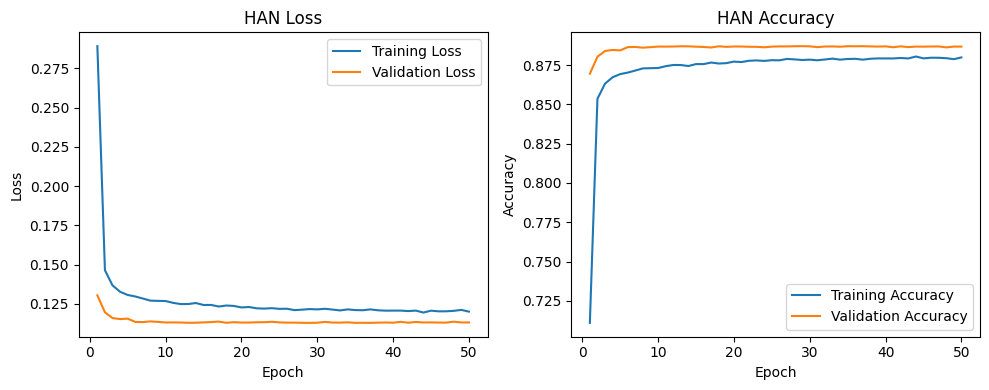

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(range(1, num_epochs+1), train_losses, label='Training Loss')
axs[0].plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('HAN Loss')
axs[0].legend()

axs[1].plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
axs[1].plot(range(1, num_epochs+1), valid_accs, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('HAN Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=True)
model = HAN(embedding_layer, hidden_dim, output_dim, dropout)
model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/HAN_model.pth'))

<All keys matched successfully>

In [ ]:
# Convert text indices of the test set to tensors
text_indices_test = torch.tensor(test_df['text_indices'].tolist())

# Create a data loader for the test set
test_data = [(torch.tensor(indices), torch.tensor(labels)) for indices, labels in zip(test_df['text_indices'], test_df[['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']].values)]
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = mae_loss(outputs, labels)
        acc = 1 - loss

        test_loss += loss.item()
        test_acc += acc.item()

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1164, Test Accuracy: 0.8836


In [ ]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 1209207
Trainable parameters: 303807


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable Parameters in {name}: {param.numel():,}")

print("\nDetailed breakdown of parameters for each layer:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,}")

Trainable Parameters in word_rnn.weight_ih_l0: 30,000
Trainable Parameters in word_rnn.weight_hh_l0: 30,000
Trainable Parameters in word_rnn.bias_ih_l0: 300
Trainable Parameters in word_rnn.bias_hh_l0: 300
Trainable Parameters in word_rnn.weight_ih_l0_reverse: 30,000
Trainable Parameters in word_rnn.weight_hh_l0_reverse: 30,000
Trainable Parameters in word_rnn.bias_ih_l0_reverse: 300
Trainable Parameters in word_rnn.bias_hh_l0_reverse: 300
Trainable Parameters in word_attention.weight: 200
Trainable Parameters in word_attention.bias: 1
Trainable Parameters in sentence_rnn.weight_ih_l0: 60,000
Trainable Parameters in sentence_rnn.weight_hh_l0: 30,000
Trainable Parameters in sentence_rnn.bias_ih_l0: 300
Trainable Parameters in sentence_rnn.bias_hh_l0: 300
Trainable Parameters in sentence_rnn.weight_ih_l0_reverse: 60,000
Trainable Parameters in sentence_rnn.weight_hh_l0_reverse: 30,000
Trainable Parameters in sentence_rnn.bias_ih_l0_reverse: 300
Trainable Parameters in sentence_rnn.bias_h

# Transformers

In [ ]:
pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.9 MB/s eta 0:00:00


In [ ]:
pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

import torch
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel, BertConfig
from torch.optim import AdamW
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

Mounted at /content/drive


In [ ]:
import pickle

# Open the pickle file
with open('/content/drive/MyDrive/NLP/transcription_training.pkl', 'rb') as f:
    data = pickle.load(f)

# Create a dictionary that maps column names to lists of values
df_dict = {
    'video_id': list(data.keys()),
    'text': list(data.values())
}

# Convert the dictionary to a pandas DataFrame
df1 = pd.DataFrame(df_dict)
df1

video_id                                               text
0     J4GQm9j0JZ0.003.mp4  He's cutting it and then turn around and see t...
1     zEyRyTnIw5I.005.mp4  Responsibility to house the organ I had been g...
2     nskJh7v6v1U.004.mp4  I actually got quite a few sets of black pens ...
3     6wHQsN5g2RM.000.mp4  I ate a lot. I'd like a lot of foods. I rememb...
4     dQOeQYWIgm8.000.mp4  Now I'll ask you guys to leave a question in t...
...                   ...                                                ...
5995  mhF4kYTlVUE.001.mp4  I got to see a lot, got to experience a lot. Y...
5996  2q8orkMs2Jg.003.mp4  Really, really love my job, love the people I ...
5997  F1lAPYh4t3U.000.mp4  I have a nine-to-five. I said this in my last ...
5998  cxJ0u6r0-pU.001.mp4  You want to be working with and who you want t...
5999  hfUH9Am-Izs.000.mp4  No, but, it's really hard to explain. It reall...

[6000 rows x 2 columns]

In [ ]:
# load labels data
with open('/content/drive/MyDrive/NLP/annotation_training.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

# Convert the dictionary to a DataFrame
df11 = pd.DataFrame.from_dict(data)

# Transpose the DataFrame so that each row contains a video_id and the probabilities for each personality trait
df11 = df11.reset_index()

# # Rename the columns
df11.columns = ['video_id', 'extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'interview', 'openness']
df11

video_id  extraversion  neuroticism  agreeableness  \
0     J4GQm9j0JZ0.003.mp4      0.523364     0.552083       0.626374   
1     zEyRyTnIw5I.005.mp4      0.345794     0.375000       0.472527   
2     nskJh7v6v1U.004.mp4      0.252336     0.291667       0.406593   
3     6wHQsN5g2RM.000.mp4      0.457944     0.489583       0.505495   
4     dQOeQYWIgm8.000.mp4      0.607477     0.489583       0.406593   
...                   ...           ...          ...            ...   
5995  Eh7WRYXVh9M.000.mp4      0.523364     0.479167       0.626374   
5996  2q8orkMs2Jg.003.mp4      0.728972     0.760417       0.582418   
5997  F1lAPYh4t3U.000.mp4      0.700935     0.770833       0.747253   
5998  cxJ0u6r0-pU.001.mp4      0.317757     0.531250       0.582418   
5999  hfUH9Am-Izs.000.mp4      0.401869     0.500000       0.461538   

      conscientiousness  interview  openness  
0              0.601942   0.504673  0.488889  
1              0.582524   0.457944  0.366667  
2              0.485437   0.373832  0.511111  
3              0.398058   0.457944  0.377778  
4              0.621359   0.570093  0.622222  
...                 ...        ...       ...  
5995           0.621359   0.588785  0.544444  
5996           0.524272   0.616822  0.822222  
5997           0.699029   0.691589  0.788889  
5998           0.679612   0.616822  0.588889  
5999           0.543689   0.429907  0.588889  

[6000 rows x 7 columns]

In [ ]:
training_df = pd.merge(df1, df11, on='video_id')
training_df = training_df.drop(['interview', 'video_id'], axis=1)
training_df = training_df.dropna(subset=['text'])
training_df

text  extraversion  \
0     He's cutting it and then turn around and see t...      0.523364   
1     Responsibility to house the organ I had been g...      0.345794   
2     I actually got quite a few sets of black pens ...      0.252336   
3     I ate a lot. I'd like a lot of foods. I rememb...      0.457944   
4     Now I'll ask you guys to leave a question in t...      0.607477   
...                                                 ...           ...   
5995  I got to see a lot, got to experience a lot. Y...      0.401869   
5996  Really, really love my job, love the people I ...      0.728972   
5997  I have a nine-to-five. I said this in my last ...      0.700935   
5998  You want to be working with and who you want t...      0.317757   
5999  No, but, it's really hard to explain. It reall...      0.401869   

      neuroticism  agreeableness  conscientiousness  openness  
0        0.552083       0.626374           0.601942  0.488889  
1        0.375000       0.472527           0.582524  0.366667  
2        0.291667       0.406593           0.485437  0.511111  
3        0.489583       0.505495           0.398058  0.377778  
4        0.489583       0.406593           0.621359  0.622222  
...           ...            ...                ...       ...  
5995     0.427083       0.571429           0.485437  0.466667  
5996     0.760417       0.582418           0.524272  0.822222  
5997     0.770833       0.747253           0.699029  0.788889  
5998     0.531250       0.582418           0.679612  0.588889  
5999     0.500000       0.461538           0.543689  0.588889  

[6000 rows x 6 columns]

In [ ]:
# Open the pickle file
with open('/content/drive/MyDrive/NLP/transcription_validation.pkl', 'rb') as f:
    data = pickle.load(f)

# Create a dictionary that maps column names to lists of values
df_dict = {
    'video_id': list(data.keys()),
    'text': list(data.values())
}

# Convert the dictionary to a pandas DataFrame
df2 = pd.DataFrame(df_dict)
df2

video_id                                               text
0     LNM1i-a9q_A.005.mp4  [inaudible 00:00:16] and then I will do the vo...
1     n6JNJurop2U.005.mp4  Personality is A1, I like you. So that is all ...
2     WER4ww680QQ.004.mp4  Ewe. But yeah, some people been asking me if I...
3     c4XnKouozXU.002.mp4  I am a makeup artist, I am an aesthetician, I ...
4     OEKg-Tvwcbk.002.mp4  Sucks. When he agrees, yeah. It just sucks bec...
...                   ...                                                ...
1995  3LAaFUSGvsU.000.mp4  Really qualified to. The guy who last week was...
1996  n2BuwHbdilY.000.mp4  Wearing scarfs on the second date. Okay, so no...
1997  GcuoyJPO-KU.003.mp4  "How do you manage to do things with someone? ...
1998  uf_sIIw4zxY.004.mp4  -I sell. No. Sophie Loveland, "Will you be pos...
1999  jd9_8OPxM3A.003.mp4  -to live together and to create a world where ...

[2000 rows x 2 columns]

In [ ]:
# load labels data
with open('/content/drive/MyDrive/NLP/annotation_validation.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

# Convert the dictionary to a DataFrame
df22 = pd.DataFrame.from_dict(data)

# Transpose the DataFrame so that each row contains a video_id and the probabilities for each personality trait
df22 = df22.reset_index()

# # Rename the columns
df22.columns = ['video_id', 'extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'interview', 'openness']
df22

video_id  extraversion  neuroticism  agreeableness  \
0     modNfUPt3F4.002.mp4      0.644860     0.593750       0.615385   
1     h6LOjpCRXtY.005.mp4      0.439252     0.520833       0.417582   
2     WER4ww680QQ.004.mp4      0.457944     0.312500       0.428571   
3     c4XnKouozXU.002.mp4      0.364486     0.572917       0.527473   
4     OEKg-Tvwcbk.002.mp4      0.345794     0.468750       0.516484   
...                   ...           ...          ...            ...   
1995  3LAaFUSGvsU.000.mp4      0.570093     0.614583       0.494505   
1996  n2BuwHbdilY.000.mp4      0.542056     0.541667       0.549451   
1997  GcuoyJPO-KU.003.mp4      0.551402     0.593750       0.560440   
1998  uf_sIIw4zxY.004.mp4      0.514019     0.552083       0.461538   
1999  jd9_8OPxM3A.003.mp4      0.560748     0.635417       0.725275   

      conscientiousness  interview  openness  
0              0.640777   0.616822  0.555556  
1              0.572816   0.439252  0.411111  
2              0.398058   0.373832  0.555556  
3              0.553398   0.523364  0.322222  
4              0.417476   0.383178  0.477778  
...                 ...        ...       ...  
1995           0.689320   0.626168  0.577778  
1996           0.669903   0.579439  0.666667  
1997           0.572816   0.504673  0.644444  
1998           0.572816   0.551402  0.733333  
1999           0.621359   0.635514  0.666667  

[2000 rows x 7 columns]

In [ ]:
validation_df = pd.merge(df2, df22, on='video_id')
validation_df = validation_df.drop(['interview', 'video_id'], axis=1)
validation_df = validation_df.dropna(subset=['text'])
validation_df

text  extraversion  \
0     [inaudible 00:00:16] and then I will do the vo...      0.551402   
1     Personality is A1, I like you. So that is all ...      0.598131   
2     Ewe. But yeah, some people been asking me if I...      0.457944   
3     I am a makeup artist, I am an aesthetician, I ...      0.364486   
4     Sucks. When he agrees, yeah. It just sucks bec...      0.345794   
...                                                 ...           ...   
1995  Really qualified to. The guy who last week was...      0.570093   
1996  Wearing scarfs on the second date. Okay, so no...      0.542056   
1997  "How do you manage to do things with someone? ...      0.551402   
1998  -I sell. No. Sophie Loveland, "Will you be pos...      0.514019   
1999  -to live together and to create a world where ...      0.560748   

      neuroticism  agreeableness  conscientiousness  openness  
0        0.770833       0.549451           0.669903  0.577778  
1        0.510417       0.692308           0.524272  0.588889  
2        0.312500       0.428571           0.398058  0.555556  
3        0.572917       0.527473           0.553398  0.322222  
4        0.468750       0.516484           0.417476  0.477778  
...           ...            ...                ...       ...  
1995     0.614583       0.494505           0.689320  0.577778  
1996     0.541667       0.549451           0.669903  0.666667  
1997     0.593750       0.560440           0.572816  0.644444  
1998     0.552083       0.461538           0.572816  0.733333  
1999     0.635417       0.725275           0.621359  0.666667  

[2000 rows x 6 columns]

In [ ]:
# Open the pickle file
with open('/content/drive/MyDrive/NLP/transcription_test.pkl', 'rb') as f:
    data = pickle.load(f)

# Create a dictionary that maps column names to lists of values
df_dict = {
    'video_id': list(data.keys()),
    'text': list(data.values())
}

# Convert the dictionary to a pandas DataFrame
df3 = pd.DataFrame(df_dict)
df3

video_id                                               text
0     htH89DBizno.004.mp4  ... Going nuts from another room, run in there...
1     p_wf-KszNlk.001.mp4  I've got a little bit to go but we need you th...
2     MuYYY3XaJ7Q.001.mp4  A video's quality over quantity, so everyone c...
3     0MB91ku0eEw.005.mp4  You really want to. That's made things a lot e...
4     WpEZOSrENL0.003.mp4  That's perfectly okay. The point isn't actuall...
...                   ...                                                ...
1995  NzCflfxgvwo.001.mp4  Du du du. No, that's not why I made this video...
1996  ch2BcBv4SdQ.003.mp4                           They do it all the time.
1997  It0-yCwOc5k.001.mp4  Comfortable and I don't want anyone to feel un...
1998  1Wh2mIFrGvk.000.mp4  You're not giving yourself enough calories to ...
1999  a97PXgrKSxo.002.mp4  Eat enough carbs, eat more fats to get in more...

[2000 rows x 2 columns]

In [ ]:
# load labels data
with open('/content/drive/MyDrive/NLP/annotation_test.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

# Convert the dictionary to a DataFrame
df33 = pd.DataFrame.from_dict(data)

# Transpose the DataFrame so that each row contains a video_id and the probabilities for each personality trait
df33 = df33.reset_index()

# # Rename the columns
df33.columns = ['video_id', 'extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'interview', 'openness']
df33

video_id  extraversion  neuroticism  agreeableness  \
0     htH89DBizno.004.mp4      0.485981     0.645833       0.681319   
1     p_wf-KszNlk.001.mp4      0.616822     0.593750       0.692308   
2     MuYYY3XaJ7Q.001.mp4      0.467290     0.625000       0.560440   
3     0MB91ku0eEw.005.mp4      0.411215     0.458333       0.714286   
4     WpEZOSrENL0.003.mp4      0.317757     0.437500       0.384615   
...                   ...           ...          ...            ...   
1995  NzCflfxgvwo.001.mp4      0.289720     0.312500       0.208791   
1996  ch2BcBv4SdQ.003.mp4      0.719626     0.781250       0.670330   
1997  It0-yCwOc5k.001.mp4      0.355140     0.395833       0.472527   
1998  1Wh2mIFrGvk.000.mp4      0.467290     0.645833       0.527473   
1999  a97PXgrKSxo.002.mp4      0.654206     0.635417       0.813187   

      conscientiousness  interview  openness  
0              0.669903   0.626168  0.822222  
1              0.514563   0.570093  0.655556  
2              0.524272   0.514019  0.522222  
3              0.660194   0.570093  0.400000  
4              0.524272   0.448598  0.411111  
...                 ...        ...       ...  
1995           0.135922   0.177570  0.300000  
1996           0.572816   0.728972  0.722222  
1997           0.446602   0.411215  0.677778  
1998           0.669903   0.560748  0.622222  
1999           0.728155   0.654206  0.588889  

[2000 rows x 7 columns]

In [ ]:
test_df = pd.merge(df3, df33, on='video_id')
test_df = test_df.drop(['interview', 'video_id'], axis=1)
test_df = test_df.dropna(subset=['text'])
test_df

text  extraversion  \
0     ... Going nuts from another room, run in there...      0.485981   
1     I've got a little bit to go but we need you th...      0.616822   
2     A video's quality over quantity, so everyone c...      0.467290   
3     You really want to. That's made things a lot e...      0.411215   
4     That's perfectly okay. The point isn't actuall...      0.317757   
...                                                 ...           ...   
1995  Du du du. No, that's not why I made this video...      0.289720   
1996                           They do it all the time.      0.719626   
1997  Comfortable and I don't want anyone to feel un...      0.355140   
1998  You're not giving yourself enough calories to ...      0.467290   
1999  Eat enough carbs, eat more fats to get in more...      0.654206   

      neuroticism  agreeableness  conscientiousness  openness  
0        0.645833       0.681319           0.669903  0.822222  
1        0.593750       0.692308           0.514563  0.655556  
2        0.625000       0.560440           0.524272  0.522222  
3        0.458333       0.714286           0.660194  0.400000  
4        0.437500       0.384615           0.524272  0.411111  
...           ...            ...                ...       ...  
1995     0.312500       0.208791           0.135922  0.300000  
1996     0.781250       0.670330           0.572816  0.722222  
1997     0.395833       0.472527           0.446602  0.677778  
1998     0.645833       0.527473           0.669903  0.622222  
1999     0.635417       0.813187           0.728155  0.588889  

[2000 rows x 6 columns]

In [ ]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.0 MB/s eta 0:00:00


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import re
import contractions

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = str(text).lower()

    # Remove links
    text = re.sub(r'https?:\/\/.*?[\s+]', '', text.replace("|", " ") + " ")

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove multiple fullstops
    text = re.sub(r'[^\w\s]','', text)

    # Remove multiple letter repeating words
    text = re.sub(r'([a-z])\1{2,}[\s|\w]*','', text)

    # Remove Non-words
    text = re.sub(r'[^a-zA-Z\s]','', text)

    # Remove very short or long words
    text = re.sub(r'(\b\w{0,2})?\b','', text)
    text = re.sub(r'(\b\w{20,1000})?\b','', text)

    # Remove numbers and special characters
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    # Expand contractions
    text = contractions.fix(text)

    # Tokenize the text using the tokenizer
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [tokenizer.decode(token_id) for token_id in inputs['input_ids'][0] if tokenizer.decode(token_id) not in stop_words]

    # Perform part-of-speech tagging
    tagged_tokens = pos_tag(filtered_tokens)

    # Lemmatize tokens based on their part-of-speech tags
    lemmatized_tokens = []
    for token, tag in tagged_tokens:
        wordnet_tag = get_wordnet_pos(tag)
        lemmatized_token = lemmatizer.lemmatize(token, pos=wordnet_tag) if wordnet_tag else lemmatizer.lemmatize(token)
        lemmatized_tokens.append(lemmatized_token)

    return lemmatized_tokens

# Function to map part-of-speech tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # Adjective
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('N'):
        return 'n'  # Noun
    elif tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return None  # None by default

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Preprocess and tokenize the data
def preprocess_and_tokenize(df):
    df['tokens'] = df['text'].apply(preprocess_text)

    # Tokenize the texts and convert to input tensors
    input_ids = []
    attention_masks = []
    for tokens in df['tokens']:
        inputs = tokenizer(' '.join(tokens), padding='max_length', truncation=True, return_tensors='pt', max_length=32)
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])

    # Stack the input tensors
    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)

    # Convert labels to tensors
    labels = torch.tensor(df[['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']].values, dtype=torch.float)
    return {'input_ids': input_ids, 'attention_mask': attention_masks}, labels

## BERT (base)

In [ ]:
# Load the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Preprocess and tokenize the training, validation, and test data
train_inputs, train_labels = preprocess_and_tokenize(training_df)
val_inputs, val_labels = preprocess_and_tokenize(validation_df)
test_inputs, test_labels = preprocess_and_tokenize(test_df)

In [ ]:
train_inputs

{'input_ids': tensor([[[ 101, 1031, 1039,  ..., 1037, 1054,  102]],
 
         [[ 101, 1031, 1039,  ..., 1054, 1043,  102]],
 
         [[ 101, 1031, 1039,  ..., 1038, 1048,  102]],
 
         ...,
 
         [[ 101, 1031, 1039,  ..., 1040, 1056,  102]],
 
         [[ 101, 1031, 1039,  ..., 1051, 1061,  102]],
 
         [[ 101, 1031, 1039,  ..., 1054, 1041,  102]]]),
 'attention_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1]],
 
         [[1, 1, 1,  ..., 1, 1, 1]],
 
         [[1, 1, 1,  ..., 1, 1, 1]],
 
         ...,
 
         [[1, 1, 1,  ..., 1, 1, 1]],
 
         [[1, 1, 1,  ..., 1, 1, 1]],
 
         [[1, 1, 1,  ..., 1, 1, 1]]])}

In [ ]:
train_labels

tensor([[0.5234, 0.5521, 0.6264, 0.6019, 0.4889],
        [0.3458, 0.3750, 0.4725, 0.5825, 0.3667],
        [0.2523, 0.2917, 0.4066, 0.4854, 0.5111],
        ...,
        [0.7009, 0.7708, 0.7473, 0.6990, 0.7889],
        [0.3178, 0.5312, 0.5824, 0.6796, 0.5889],
        [0.4019, 0.5000, 0.4615, 0.5437, 0.5889]])

In [ ]:
# Create DataLoader for training, validation, and test sets
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], val_labels)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)

In [ ]:
# Set Hyperparameters
batch_size = 64
hidden_size = 768  # BERT-base has a hidden size of 768
output_size = 5
num_epochs = 50
dropout = 0.5
learning_rate = 1e-4

In [ ]:
# Set batch size and create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Customize the BERT configuration with dropout rate
bert_config = BertConfig.from_pretrained('bert-base-uncased')
bert_config.hidden_dropout_prob = dropout
bert_config.attention_probs_dropout_prob = dropout

In [ ]:
# Load the pre-trained BERT model (without classification head)
bert_model = BertModel.from_pretrained('bert-base-uncased', config=bert_config)

In [ ]:
# Add a custom regression head on top of the BERT model
class BertRegressionModel(nn.Module):
    def __init__(self, bert_model, hidden_size, output_size):
        super(BertRegressionModel, self).__init__()
        self.bert_model = bert_model
        self.regression_head = nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        predictions = self.regression_head(pooled_output)
        return predictions

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the regression head and attach it to the BERT model
model = BertRegressionModel(bert_model, hidden_size, output_size)
model.to(device)

BertRegressionModel(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.5, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [ ]:
# Freeze the embedding layer
for param in model.bert_model.embeddings.parameters():
    param.requires_grad = False

In [ ]:
# Freeze all layers
for param in model.bert_model.parameters():
    param.requires_grad = False

In [ ]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=0.005)

In [ ]:
# Define loss function
def mae_loss(outputs, labels):
    batch_size = labels.size(0)
    loss = torch.sum(torch.abs(outputs - labels))
    return (1 / (5 * batch_size)) * loss

In [ ]:
# Train the model
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
best_valid_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        # Pass the inputs through the custom model (BERT + RegressionHead)
        predictions = model(input_ids=input_ids.squeeze(1), attention_mask=attention_mask)

        loss = mae_loss(predictions, labels)
        acc = 1 - loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            # Pass the inputs through the model (BERT + RegressionHead)
            predictions = model(input_ids=input_ids.squeeze(1), attention_mask=attention_mask)

            loss = mae_loss(predictions, labels)
            acc = 1 - loss
            valid_loss += loss.item()
            valid_acc += acc.item()

            if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/BERT_model.pth')

        valid_loss /= len(val_loader)
        valid_acc /= len(val_loader)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {valid_acc:.4f}")

Epoch 1/50, Training Loss: 0.1340, Validation Loss: 0.1240, Training Accuracy: 0.8660, Validation Accuracy: 0.8760
Epoch 2/50, Training Loss: 0.1242, Validation Loss: 0.1427, Training Accuracy: 0.8758, Validation Accuracy: 0.8573
Epoch 3/50, Training Loss: 0.1242, Validation Loss: 0.1386, Training Accuracy: 0.8758, Validation Accuracy: 0.8614
Epoch 4/50, Training Loss: 0.1230, Validation Loss: 0.1433, Training Accuracy: 0.8770, Validation Accuracy: 0.8567
Epoch 5/50, Training Loss: 0.1230, Validation Loss: 0.1273, Training Accuracy: 0.8770, Validation Accuracy: 0.8727
Epoch 6/50, Training Loss: 0.1231, Validation Loss: 0.1363, Training Accuracy: 0.8769, Validation Accuracy: 0.8637
Epoch 7/50, Training Loss: 0.1227, Validation Loss: 0.1218, Training Accuracy: 0.8773, Validation Accuracy: 0.8782
Epoch 8/50, Training Loss: 0.1229, Validation Loss: 0.1375, Training Accuracy: 0.8771, Validation Accuracy: 0.8625
Epoch 9/50, Training Loss: 0.1228, Validation Loss: 0.1274, Training Accuracy: 0

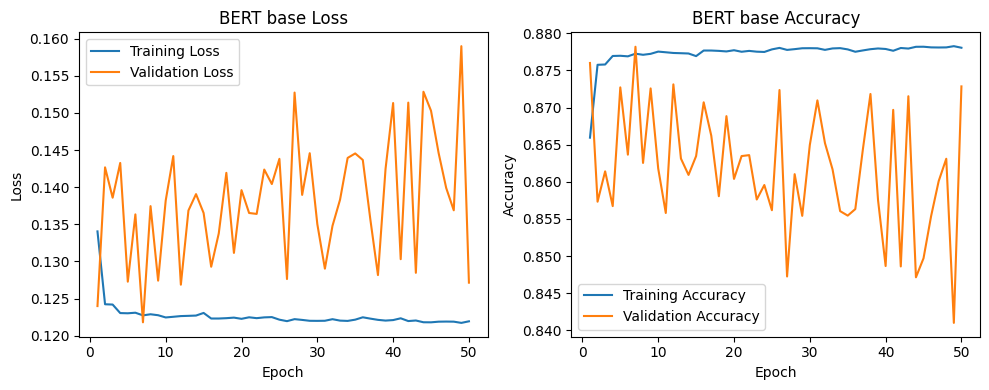

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(range(1, num_epochs+1), train_losses, label='Training Loss')
axs[0].plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('BERT base Loss')
axs[0].legend()

axs[1].plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
axs[1].plot(range(1, num_epochs+1), valid_accs, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('BERT base Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Load the best model for testing
bert_model = BertModel.from_pretrained('bert-base-uncased', config=bert_config)
model = BertRegressionModel(bert_model, hidden_size, output_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/BERT_model.pth'))
model.to(device)

BertRegressionModel(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.5, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [ ]:
# Freeze the embedding layer
for param in model.bert_model.embeddings.parameters():
    param.requires_grad = False

In [ ]:
# Freeze all layers
for param in model.bert_model.parameters():
    param.requires_grad = False

In [ ]:
# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Pass the inputs through the model (BERT + RegressionHead)
        predictions = model(input_ids=input_ids.squeeze(1), attention_mask=attention_mask)

        loss = mae_loss(predictions, labels)
        acc = 1 - loss

        test_loss += loss.item()
        test_acc += acc.item()

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1244, Test Accuracy: 0.8756


In [ ]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 109486085
Trainable parameters: 85648901


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable Parameters in {name}: {param.numel():,}")

print("\nDetailed breakdown of parameters for each layer:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,}")

Trainable Parameters in bert_model.encoder.layer.0.attention.self.query.weight: 589,824
Trainable Parameters in bert_model.encoder.layer.0.attention.self.query.bias: 768
Trainable Parameters in bert_model.encoder.layer.0.attention.self.key.weight: 589,824
Trainable Parameters in bert_model.encoder.layer.0.attention.self.key.bias: 768
Trainable Parameters in bert_model.encoder.layer.0.attention.self.value.weight: 589,824
Trainable Parameters in bert_model.encoder.layer.0.attention.self.value.bias: 768
Trainable Parameters in bert_model.encoder.layer.0.attention.output.dense.weight: 589,824
Trainable Parameters in bert_model.encoder.layer.0.attention.output.dense.bias: 768
Trainable Parameters in bert_model.encoder.layer.0.attention.output.LayerNorm.weight: 768
Trainable Parameters in bert_model.encoder.layer.0.attention.output.LayerNorm.bias: 768
Trainable Parameters in bert_model.encoder.layer.0.intermediate.dense.weight: 2,359,296
Trainable Parameters in bert_model.encoder.layer.0.int

## ALBERT (base)

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

import torch
import pandas as pd
import numpy as np
from transformers import AlbertConfig, AlbertModel, AlbertTokenizer
from torch.optim import AdamW
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the ALBERT Tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

In [ ]:
# Preprocess and tokenize the training, validation, and test data
train_inputs, train_labels = preprocess_and_tokenize(training_df)
val_inputs, val_labels = preprocess_and_tokenize(validation_df)
test_inputs, test_labels = preprocess_and_tokenize(test_df)

In [ ]:
# Create DataLoader for training, validation, and test sets
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], val_labels)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)

In [ ]:
# Set Hyperparameters
batch_size = 64
hidden_size = 768  # ALBERT-base has a hidden size of 768
output_size = 5
num_epochs = 50
dropout = 0.5
learning_rate = 1e-4

In [ ]:
# Set batch size and create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Customize the ALBERT configuration with dropout rate
albert_config = AlbertConfig.from_pretrained('albert-base-v2')
albert_config.hidden_dropout_prob = dropout
albert_config.attention_probs_dropout_prob = dropout

In [ ]:
# Load the pre-trained ALBERT model (without classification head)
albert_model = AlbertModel.from_pretrained('albert-base-v2', config=albert_config)

In [ ]:
# Add a custom regression head on top of the ALBERT model
class AlbertRegressionModel(nn.Module):
    def __init__(self, albert_model, hidden_size, output_size):
        super(AlbertRegressionModel, self).__init__()
        self.albert_model = albert_model
        self.regression_head = nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, attention_mask):
        outputs = self.albert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        predictions = self.regression_head(pooled_output)
        return predictions

In [ ]:
albert_model.config.hidden_size

768

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the regression head and attach it to the ALBERT model
model = AlbertRegressionModel(albert_model, hidden_size, output_size)
model.to(device)

AlbertRegressionModel(
  (albert_model): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, b

In [ ]:
# Freeze the embedding layer
for param in model.albert_model.embeddings.parameters():
    param.requires_grad = False

In [ ]:
# Freeze all layers
for param in model.albert_model.parameters():
    param.requires_grad = False

In [ ]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=0.005)

In [ ]:
# Define loss function
def mae_loss(outputs, labels):
    batch_size = labels.size(0)
    loss = torch.sum(torch.abs(outputs - labels))
    return (1 / (5 * batch_size)) * loss

In [ ]:
# Train the model
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
best_valid_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        # Pass the inputs through the custom model (ALBERT + RegressionHead)
        predictions = model(input_ids=input_ids.squeeze(1), attention_mask=attention_mask.squeeze(1))

        loss = mae_loss(predictions, labels)
        acc = 1 - loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            # Pass the inputs through the custom model (ALBERT + RegressionHead)
            predictions = model(input_ids=input_ids.squeeze(1), attention_mask=attention_mask.squeeze(1))  # ALBERT has no pooler_output
            loss = mae_loss(predictions, labels)
            acc = 1 - loss
            valid_loss += loss.item()
            valid_acc += acc.item()

            if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/ALBERT_model.pth')

        valid_loss /= len(val_loader)
        valid_acc /= len(val_loader)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {valid_acc:.4f}")

Epoch 1/50, Training Loss: 0.1726, Validation Loss: 0.3589, Training Accuracy: 0.8274, Validation Accuracy: 0.6411
Epoch 2/50, Training Loss: 0.1364, Validation Loss: 0.2184, Training Accuracy: 0.8636, Validation Accuracy: 0.7816
Epoch 3/50, Training Loss: 0.1296, Validation Loss: 0.1559, Training Accuracy: 0.8704, Validation Accuracy: 0.8441
Epoch 4/50, Training Loss: 0.1273, Validation Loss: 0.1348, Training Accuracy: 0.8727, Validation Accuracy: 0.8652
Epoch 5/50, Training Loss: 0.1269, Validation Loss: 0.1318, Training Accuracy: 0.8731, Validation Accuracy: 0.8682
Epoch 6/50, Training Loss: 0.1249, Validation Loss: 0.1258, Training Accuracy: 0.8751, Validation Accuracy: 0.8742
Epoch 7/50, Training Loss: 0.1250, Validation Loss: 0.1403, Training Accuracy: 0.8750, Validation Accuracy: 0.8597
Epoch 8/50, Training Loss: 0.1242, Validation Loss: 0.1190, Training Accuracy: 0.8758, Validation Accuracy: 0.8810
Epoch 9/50, Training Loss: 0.1237, Validation Loss: 0.1200, Training Accuracy: 0

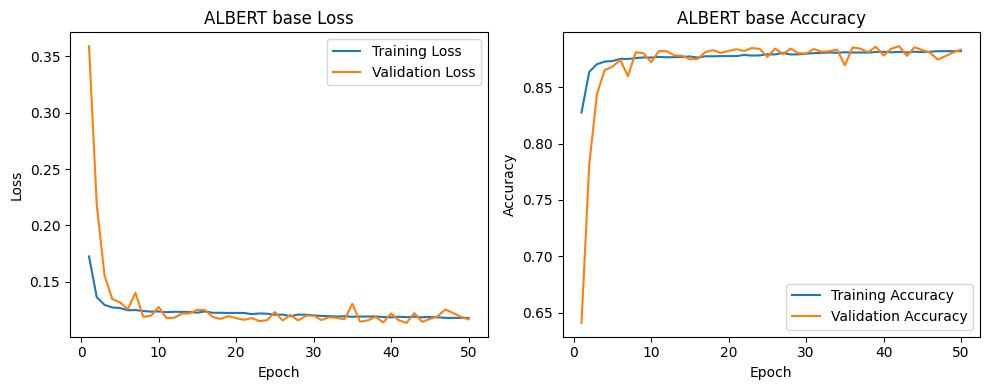

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(range(1, num_epochs+1), train_losses, label='Training Loss')
axs[0].plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('ALBERT base Loss')
axs[0].legend()

axs[1].plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
axs[1].plot(range(1, num_epochs+1), valid_accs, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('ALBERT base Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Load the best model for testing
albert_model = AlbertModel.from_pretrained('albert-base-v2', config=albert_config)
model = AlbertRegressionModel(albert_model, hidden_size, output_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/ALBERT_model.pth'))
model.to(device)

AlbertRegressionModel(
  (albert_model): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, b

In [ ]:
# Freeze the embedding layer
for param in model.albert_model.embeddings.parameters():
    param.requires_grad = False

In [ ]:
# Freeze all layers
for param in model.albert_model.parameters():
    param.requires_grad = False

In [ ]:
# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Pass the inputs through the model (ALBERT + RegressionHead)
        predictions = model(input_ids=input_ids.squeeze(1), attention_mask=attention_mask.squeeze(1))

        loss = mae_loss(predictions, labels)
        acc = 1 - loss

        test_loss += loss.item()
        test_acc += acc.item()

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1192, Test Accuracy: 0.8808


In [ ]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 11687429
Trainable parameters: 7781381


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable Parameters in {name}: {param.numel():,}")

print("\nDetailed breakdown of parameters for each layer:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,}")

Trainable Parameters in albert_model.encoder.embedding_hidden_mapping_in.weight: 98,304
Trainable Parameters in albert_model.encoder.embedding_hidden_mapping_in.bias: 768
Trainable Parameters in albert_model.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight: 768
Trainable Parameters in albert_model.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias: 768
Trainable Parameters in albert_model.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight: 589,824
Trainable Parameters in albert_model.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias: 768
Trainable Parameters in albert_model.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight: 589,824
Trainable Parameters in albert_model.encoder.albert_layer_groups.0.albert_layers.0.attention.key.bias: 768
Trainable Parameters in albert_model.encoder.albert_layer_groups.0.albert_layers.0.attention.value.weight: 589,824
Trainable Parameters in albert_model.e

## ELECTRA (small)

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

import torch
import pandas as pd
import numpy as np
from transformers import ElectraModel, ElectraConfig, ElectraTokenizer
from torch.optim import AdamW
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the ELECTRA Tokenizer
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

In [ ]:
# Preprocess and tokenize the training, validation, and test data
train_inputs, train_labels = preprocess_and_tokenize(training_df)
val_inputs, val_labels = preprocess_and_tokenize(validation_df)
test_inputs, test_labels = preprocess_and_tokenize(test_df)

In [ ]:
# Create DataLoader for training, validation, and test sets
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], val_labels)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)

In [ ]:
# Set Hyperparameters
batch_size = 64
hidden_size = 256  # ELECTRA-small has a hidden size of 256
output_size = 5
num_epochs = 50
dropout = 0.5
learning_rate = 1e-4

In [ ]:
# Set batch size and create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Customize the ELECTRA configuration with dropout rate
electra_config = ElectraConfig.from_pretrained('google/electra-small-discriminator')
electra_config.hidden_dropout_prob = dropout
electra_config.attention_probs_dropout_prob = dropout

In [ ]:
# Load the pre-trained ELECTRA model (without classification head)
electra_model = ElectraModel.from_pretrained('google/electra-small-discriminator', config=electra_config)

In [ ]:
# Add a custom regression head on top of the ELECTRA model
class ElectraRegressionModel(nn.Module):
    def __init__(self, electra_model, hidden_size, output_size):
        super(ElectraRegressionModel, self).__init__()
        self.electra_model = electra_model
        self.regression_head = nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, attention_mask):
        outputs = self.electra_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token's representation
        predictions = self.regression_head(pooled_output)
        return predictions

In [ ]:
electra_model.config.hidden_size

256

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the regression head and attach it to the ALBERT model
model = ElectraRegressionModel(electra_model, hidden_size, output_size)
model.to(device)

ElectraRegressionModel(
  (electra_model): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.5, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear

In [ ]:
# Freeze the embedding layer
for param in model.electra_model.embeddings.parameters():
    param.requires_grad = False

In [ ]:
# Freeze all layers
for param in model.electra_model.parameters():
    param.requires_grad = False

In [ ]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=0.005)

In [ ]:
# Define loss function
def mae_loss(outputs, labels):
    batch_size = labels.size(0)
    loss = torch.sum(torch.abs(outputs - labels))
    return (1 / (5 * batch_size)) * loss

In [ ]:
# Train the model
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
best_valid_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        # Pass the inputs through the custom model (ELECTRA + RegressionHead)
        predictions = model(input_ids=input_ids.squeeze(1), attention_mask=attention_mask.squeeze(1))

        loss = mae_loss(predictions, labels)
        acc = 1 - loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            # Pass the inputs through the custom model (ELECTRA + RegressionHead)
            predictions = model(input_ids=input_ids.squeeze(1), attention_mask=attention_mask.squeeze(1))
            loss = mae_loss(predictions, labels)
            acc = 1 - loss
            valid_loss += loss.item()
            valid_acc += acc.item()

            if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/ELECTRA_model.pth')

        valid_loss /= len(val_loader)
        valid_acc /= len(val_loader)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {valid_acc:.4f}")

Epoch 1/50, Training Loss: 0.2533, Validation Loss: 0.1764, Training Accuracy: 0.7467, Validation Accuracy: 0.8236
Epoch 2/50, Training Loss: 0.1840, Validation Loss: 0.1367, Training Accuracy: 0.8160, Validation Accuracy: 0.8633
Epoch 3/50, Training Loss: 0.1621, Validation Loss: 0.1387, Training Accuracy: 0.8379, Validation Accuracy: 0.8613
Epoch 4/50, Training Loss: 0.1504, Validation Loss: 0.1381, Training Accuracy: 0.8496, Validation Accuracy: 0.8619
Epoch 5/50, Training Loss: 0.1419, Validation Loss: 0.1394, Training Accuracy: 0.8581, Validation Accuracy: 0.8606
Epoch 6/50, Training Loss: 0.1374, Validation Loss: 0.1251, Training Accuracy: 0.8626, Validation Accuracy: 0.8749
Epoch 7/50, Training Loss: 0.1348, Validation Loss: 0.1285, Training Accuracy: 0.8652, Validation Accuracy: 0.8715
Epoch 8/50, Training Loss: 0.1314, Validation Loss: 0.1211, Training Accuracy: 0.8686, Validation Accuracy: 0.8789
Epoch 9/50, Training Loss: 0.1300, Validation Loss: 0.1235, Training Accuracy: 0

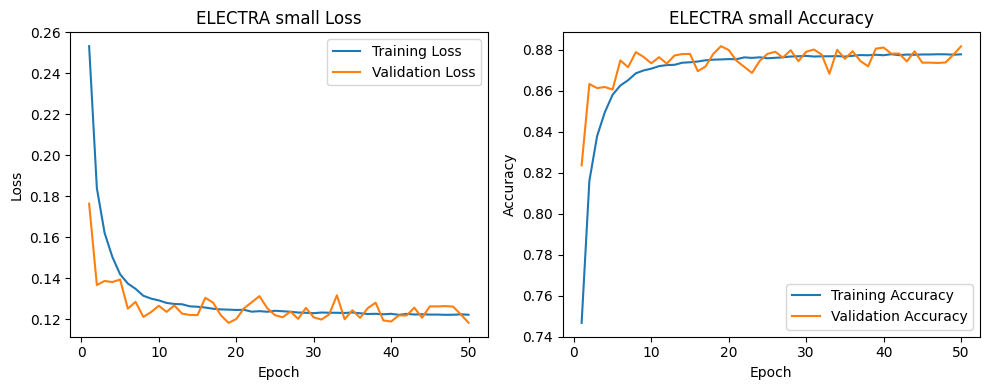

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(range(1, num_epochs+1), train_losses, label='Training Loss')
axs[0].plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('ELECTRA small Loss')
axs[0].legend()

axs[1].plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
axs[1].plot(range(1, num_epochs+1), valid_accs, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('ELECTRA small Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Load the best model for testing
electra_model = ElectraModel.from_pretrained('google/electra-small-discriminator', config=electra_config)
model = ElectraRegressionModel(electra_model, hidden_size, output_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/ELECTRA_model.pth'))
model.to(device)

ElectraRegressionModel(
  (electra_model): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.5, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear

In [ ]:
# Freeze the embedding layer
for param in model.electra_model.embeddings.parameters():
    param.requires_grad = False

In [ ]:
# Freeze all layers
for param in model.electra_model.parameters():
    param.requires_grad = False

In [ ]:
# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Pass the inputs through the model (ELECTRA + RegressionHead)
        predictions = model(input_ids=input_ids.squeeze(1), attention_mask=attention_mask.squeeze(1))

        loss = mae_loss(predictions, labels)
        acc = 1 - loss

        test_loss += loss.item()
        test_acc += acc.item()

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1219, Test Accuracy: 0.8781


In [ ]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 13484293
Trainable parameters: 9511429


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable Parameters in {name}: {param.numel():,}")

print("\nDetailed breakdown of parameters for each layer:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,}")

Trainable Parameters in electra_model.embeddings_project.weight: 32,768
Trainable Parameters in electra_model.embeddings_project.bias: 256
Trainable Parameters in electra_model.encoder.layer.0.attention.self.query.weight: 65,536
Trainable Parameters in electra_model.encoder.layer.0.attention.self.query.bias: 256
Trainable Parameters in electra_model.encoder.layer.0.attention.self.key.weight: 65,536
Trainable Parameters in electra_model.encoder.layer.0.attention.self.key.bias: 256
Trainable Parameters in electra_model.encoder.layer.0.attention.self.value.weight: 65,536
Trainable Parameters in electra_model.encoder.layer.0.attention.self.value.bias: 256
Trainable Parameters in electra_model.encoder.layer.0.attention.output.dense.weight: 65,536
Trainable Parameters in electra_model.encoder.layer.0.attention.output.dense.bias: 256
Trainable Parameters in electra_model.encoder.layer.0.attention.output.LayerNorm.weight: 256
Trainable Parameters in electra_model.encoder.layer.0.attention.outp

## DistilBERT (base)

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

import torch
import pandas as pd
import numpy as np
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from torch.optim import AdamW
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the DistilBert Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
# Preprocess and tokenize the training, validation, and test data
train_inputs, train_labels = preprocess_and_tokenize(training_df)
val_inputs, val_labels = preprocess_and_tokenize(validation_df)
test_inputs, test_labels = preprocess_and_tokenize(test_df)

In [ ]:
# Create DataLoader for training, validation, and test sets
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], val_labels)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)

In [ ]:
# Set Hyperparameters
batch_size = 64
hidden_size = 768  # DistilBert-base has a hidden size of 768
output_size = 5
num_epochs = 50
dropout = 0.5
learning_rate = 1e-4

In [ ]:
# Set batch size and create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Customize the DistilBERT configuration with dropout rate
distilbert_config = DistilBertConfig.from_pretrained('distilbert-base-uncased')
distilbert_config.hidden_dropout_prob = dropout
distilbert_config.attention_dropout_prob = dropout

In [ ]:
# Load the pre-trained DistilBERT model (without classification head)
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased', config=distilbert_config)

In [ ]:
# Add a custom regression head on top of the DistilBERT model
class DistilBERTRegressionModel(nn.Module):
    def __init__(self, distilbert_model, hidden_size, output_size):
        super(DistilBERTRegressionModel, self).__init__()
        self.distilbert_model = distilbert_model
        self.regression_head = nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token's representation
        predictions = self.regression_head(pooled_output)
        return predictions

In [ ]:
distilbert_model.config.hidden_size

768

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the regression head and attach it to the DistilBert model
model = DistilBERTRegressionModel(distilbert_model, hidden_size, output_size)
model.to(device)

DistilBERTRegressionModel(
  (distilbert_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
     

In [ ]:
# Freeze the embedding layer
for param in model.distilbert_model.embeddings.parameters():
    param.requires_grad = False

In [ ]:
# Freeze all layers
for param in model.distilbert_model.parameters():
    param.requires_grad = False

In [ ]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=0.005)

In [ ]:
# Define loss function
def mae_loss(outputs, labels):
    batch_size = labels.size(0)
    loss = torch.sum(torch.abs(outputs - labels))
    return (1 / (5 * batch_size)) * loss

In [ ]:
# Train the model
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
best_valid_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        # Pass the inputs through the custom model (DistilBERT + RegressionHead)
        predictions = model(input_ids=input_ids.squeeze(1), attention_mask=attention_mask.squeeze(1))

        loss = mae_loss(predictions, labels)
        acc = 1 - loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            # Pass the inputs through the custom model (DistilBERT + RegressionHead)
            predictions = model(input_ids=input_ids.squeeze(1), attention_mask=attention_mask.squeeze(1))
            loss = mae_loss(predictions, labels)
            acc = 1 - loss
            valid_loss += loss.item()
            valid_acc += acc.item()

            if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/DistilBERT_model.pth')

        valid_loss /= len(val_loader)
        valid_acc /= len(val_loader)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {valid_acc:.4f}")

Epoch 1/50, Training Loss: 0.1392, Validation Loss: 0.1212, Training Accuracy: 0.8608, Validation Accuracy: 0.8788
Epoch 2/50, Training Loss: 0.1251, Validation Loss: 0.1243, Training Accuracy: 0.8749, Validation Accuracy: 0.8757
Epoch 3/50, Training Loss: 0.1249, Validation Loss: 0.1212, Training Accuracy: 0.8751, Validation Accuracy: 0.8788
Epoch 4/50, Training Loss: 0.1237, Validation Loss: 0.1185, Training Accuracy: 0.8763, Validation Accuracy: 0.8815
Epoch 5/50, Training Loss: 0.1244, Validation Loss: 0.1184, Training Accuracy: 0.8756, Validation Accuracy: 0.8816
Epoch 6/50, Training Loss: 0.1231, Validation Loss: 0.1185, Training Accuracy: 0.8769, Validation Accuracy: 0.8815
Epoch 7/50, Training Loss: 0.1225, Validation Loss: 0.1178, Training Accuracy: 0.8775, Validation Accuracy: 0.8822
Epoch 8/50, Training Loss: 0.1221, Validation Loss: 0.1186, Training Accuracy: 0.8779, Validation Accuracy: 0.8814
Epoch 9/50, Training Loss: 0.1215, Validation Loss: 0.1279, Training Accuracy: 0

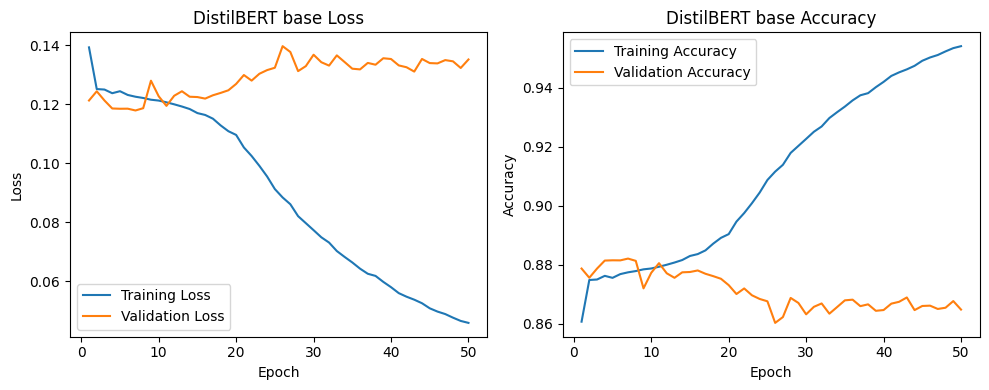

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(range(1, num_epochs+1), train_losses, label='Training Loss')
axs[0].plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('DistilBERT base Loss')
axs[0].legend()

axs[1].plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
axs[1].plot(range(1, num_epochs+1), valid_accs, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('DistilBERT base Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Load the best model for testing
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased', config=distilbert_config)
model = DistilBERTRegressionModel(distilbert_model, hidden_size, output_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/DistilBERT_model.pth'))
model.to(device)

DistilBERTRegressionModel(
  (distilbert_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
     

In [ ]:
# Freeze the embedding layer
for param in model.distilbert_model.embeddings.parameters():
    param.requires_grad = False

In [ ]:
# Freeze all layers
for param in model.distilbert_model.parameters():
    param.requires_grad = False

In [ ]:
# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Pass the inputs through the model (DistilBert + RegressionHead)
        predictions = model(input_ids=input_ids.squeeze(1), attention_mask=attention_mask.squeeze(1))

        loss = mae_loss(predictions, labels)
        acc = 1 - loss

        test_loss += loss.item()
        test_acc += acc.item()

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1255, Test Accuracy: 0.8745


In [ ]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 66366725
Trainable parameters: 42531077


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable Parameters in {name}: {param.numel():,}")

print("\nDetailed breakdown of parameters for each layer:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,}")

Trainable Parameters in distilbert_model.transformer.layer.0.attention.q_lin.weight: 589,824
Trainable Parameters in distilbert_model.transformer.layer.0.attention.q_lin.bias: 768
Trainable Parameters in distilbert_model.transformer.layer.0.attention.k_lin.weight: 589,824
Trainable Parameters in distilbert_model.transformer.layer.0.attention.k_lin.bias: 768
Trainable Parameters in distilbert_model.transformer.layer.0.attention.v_lin.weight: 589,824
Trainable Parameters in distilbert_model.transformer.layer.0.attention.v_lin.bias: 768
Trainable Parameters in distilbert_model.transformer.layer.0.attention.out_lin.weight: 589,824
Trainable Parameters in distilbert_model.transformer.layer.0.attention.out_lin.bias: 768
Trainable Parameters in distilbert_model.transformer.layer.0.sa_layer_norm.weight: 768
Trainable Parameters in distilbert_model.transformer.layer.0.sa_layer_norm.bias: 768
Trainable Parameters in distilbert_model.transformer.layer.0.ffn.lin1.weight: 2,359,296
Trainable Parame

## FLAN-T5 (small)

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

import torch
import pandas as pd
import numpy as np
from transformers import T5Model, T5Config, T5Tokenizer
from torch.optim import AdamW
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the FLAN-T5 Tokenizer
tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-small')

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


In [ ]:
# Preprocess and tokenize the training, validation, and test data
train_inputs, train_labels = preprocess_and_tokenize(training_df)
val_inputs, val_labels = preprocess_and_tokenize(validation_df)
test_inputs, test_labels = preprocess_and_tokenize(test_df)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:262: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:262: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:262: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


In [ ]:
# Create DataLoader for training, validation, and test sets
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], val_labels)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)

In [ ]:
# Set Hyperparameters
batch_size = 64
hidden_size = 512  # FLAN-T5-small has a hidden size of 512
output_size = 5
num_epochs = 50
dropout = 0.5
learning_rate = 1e-4

In [ ]:
# Set batch size and create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Customize the FLAN-T5 configuration with dropout rate
T5_config = T5Config.from_pretrained('google/flan-t5-small')
T5_config.hidden_dropout_prob = dropout
T5_config.attention_dropout_prob = dropout

In [ ]:
# Load the pre-trained FLAN-T5 model (without classification head)
T5_model = T5Model.from_pretrained('google/flan-t5-small', config=T5_config)

In [ ]:
# Remove the decoder part from the model
T5_model = T5_model.encoder

In [ ]:
# Add a custom regression head on top of the FLAN-T5 model
class T5RegressionModel(nn.Module):
    def __init__(self, T5_model, hidden_size, output_size):
        super(T5RegressionModel, self).__init__()
        self.T5_model = T5_model
        self.regression_head = nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, attention_mask):
        outputs = self.T5_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token's representation
        predictions = self.regression_head(pooled_output)
        return predictions

In [ ]:
T5_model.config.hidden_size

512

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the regression head and attach it to the FLAN-T5 model
model = T5RegressionModel(T5_model, hidden_size, output_size)
model.to(device)

T5RegressionModel(
  (T5_model): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): Linear(in_features=1024, out_features=512,

In [ ]:
# Freeze the embedding layer
for param in model.T5_model.embed_tokens.parameters():
    param.requires_grad = False

In [ ]:
# Freeze all layers
for param in model.T5_model.parameters():
    param.requires_grad = False

In [ ]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=0.005)

In [ ]:
# Define loss function
def mae_loss(outputs, labels):
    batch_size = labels.size(0)
    loss = torch.sum(torch.abs(outputs - labels))
    return (1 / (5 * batch_size)) * loss

In [ ]:
# Train the model
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
best_valid_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        # Pass the inputs through the custom model (FLAN-T5 + RegressionHead)
        predictions = model(input_ids=input_ids.squeeze(1), attention_mask=attention_mask.squeeze(1))

        loss = mae_loss(predictions, labels)
        acc = 1 - loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            # Pass the inputs through the custom model (FLAN-T5 + RegressionHead)
            predictions = model(input_ids=input_ids.squeeze(1), attention_mask=attention_mask.squeeze(1))
            loss = mae_loss(predictions, labels)
            acc = 1 - loss
            valid_loss += loss.item()
            valid_acc += acc.item()

            if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/FLAN-T5_model.pth')

        valid_loss /= len(val_loader)
        valid_acc /= len(val_loader)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {valid_acc:.4f}")

Epoch 1/50, Training Loss: 0.2084, Validation Loss: 0.1390, Training Accuracy: 0.7916, Validation Accuracy: 0.8610
Epoch 2/50, Training Loss: 0.1431, Validation Loss: 0.1353, Training Accuracy: 0.8569, Validation Accuracy: 0.8647
Epoch 3/50, Training Loss: 0.1387, Validation Loss: 0.1298, Training Accuracy: 0.8613, Validation Accuracy: 0.8702
Epoch 4/50, Training Loss: 0.1351, Validation Loss: 0.1276, Training Accuracy: 0.8649, Validation Accuracy: 0.8724
Epoch 5/50, Training Loss: 0.1312, Validation Loss: 0.1280, Training Accuracy: 0.8688, Validation Accuracy: 0.8720
Epoch 6/50, Training Loss: 0.1274, Validation Loss: 0.1155, Training Accuracy: 0.8726, Validation Accuracy: 0.8845
Epoch 7/50, Training Loss: 0.1197, Validation Loss: 0.1162, Training Accuracy: 0.8803, Validation Accuracy: 0.8838
Epoch 8/50, Training Loss: 0.1172, Validation Loss: 0.1160, Training Accuracy: 0.8828, Validation Accuracy: 0.8840
Epoch 9/50, Training Loss: 0.1142, Validation Loss: 0.1165, Training Accuracy: 0

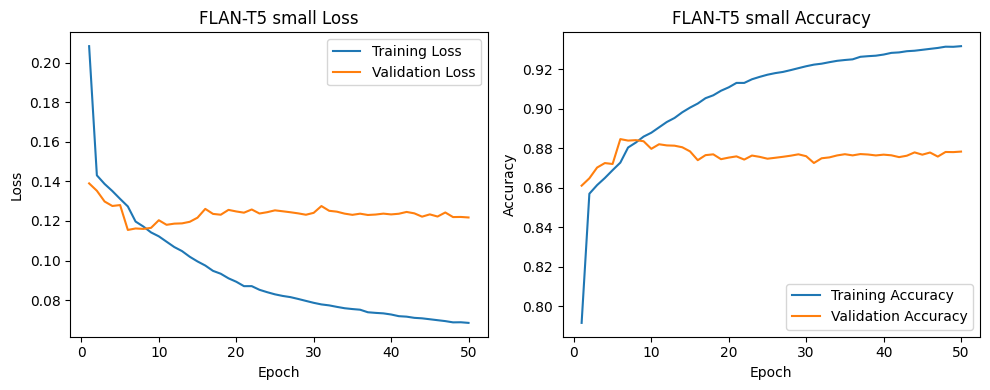

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(range(1, num_epochs+1), train_losses, label='Training Loss')
axs[0].plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('FLAN-T5 small Loss')
axs[0].legend()

axs[1].plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
axs[1].plot(range(1, num_epochs+1), valid_accs, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('FLAN-T5 small Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Load the best model for testing
T5_model = T5Model.from_pretrained('google/flan-t5-small', config=T5_config)
T5_model = T5_model.encoder
model = T5RegressionModel(T5_model, hidden_size, output_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/FLAN-T5_model.pth'))
model.to(device)

T5RegressionModel(
  (T5_model): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): Linear(in_features=1024, out_features=512,

In [ ]:
# Freeze the embedding layer
for param in model.T5_model.embed_tokens.parameters():
    param.requires_grad = False

In [ ]:
# Freeze all layers
for param in model.T5_model.parameters():
    param.requires_grad = False

In [ ]:
# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Pass the inputs through the model (FLAN-T5 + RegressionHead)
        predictions = model(input_ids=input_ids.squeeze(1), attention_mask=attention_mask.squeeze(1))

        loss = mae_loss(predictions, labels)
        acc = 1 - loss

        test_loss += loss.item()
        test_acc += acc.item()

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1196, Test Accuracy: 0.8804


In [ ]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 35335365
Trainable parameters: 18885829


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable Parameters in {name}: {param.numel():,}")

print("\nDetailed breakdown of parameters for each layer:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,}")

Trainable Parameters in T5_model.block.0.layer.0.SelfAttention.q.weight: 196,608
Trainable Parameters in T5_model.block.0.layer.0.SelfAttention.k.weight: 196,608
Trainable Parameters in T5_model.block.0.layer.0.SelfAttention.v.weight: 196,608
Trainable Parameters in T5_model.block.0.layer.0.SelfAttention.o.weight: 196,608
Trainable Parameters in T5_model.block.0.layer.0.SelfAttention.relative_attention_bias.weight: 192
Trainable Parameters in T5_model.block.0.layer.0.layer_norm.weight: 512
Trainable Parameters in T5_model.block.0.layer.1.DenseReluDense.wi_0.weight: 524,288
Trainable Parameters in T5_model.block.0.layer.1.DenseReluDense.wi_1.weight: 524,288
Trainable Parameters in T5_model.block.0.layer.1.DenseReluDense.wo.weight: 524,288
Trainable Parameters in T5_model.block.0.layer.1.layer_norm.weight: 512
Trainable Parameters in T5_model.block.1.layer.0.SelfAttention.q.weight: 196,608
Trainable Parameters in T5_model.block.1.layer.0.SelfAttention.k.weight: 196,608
Trainable Paramete

#Results

Scan the QR-Code below to see all results

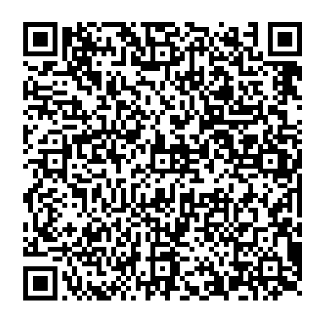